## Reproducing Figs of K25 with the vectorized version of the function

Same like 00_Test_Figs_K25_z.ipynb except with the vectorized version on dimension z and with fewer figures at the end of the notebook.


In [1]:
# General
import glob
import re
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import pandas as pd

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit
from scipy.interpolate import griddata

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
#########################
### General functions ###
#########################
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                             # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter assuming it's constant 
    return fcor

def holland_profile(r, lat, B, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor   = abs(coriolis(lat))
    rho    = 1.15
    r      = r.astype(float) + 0.001           # To avoid dividing by zero
    r_star = (Rmax / r) ** B
    V      = r * 0.
    V      = Vmin + np.sqrt( ((Vmax - Vmin) ** 2) * r_star * np.exp(1 - r_star) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

#########################
### KEPERT 2025 MODEL ###
#########################
# Inertial stability
def I(Rs, Vs, fcor):
    dr   = np.diff(Rs[0, 0, :])[0] # meters
    ksi  = 2 * Vs / Rs + fcor
    zeta = np.gradient(Vs, dr, axis=2) + Vs / Rs + fcor
    return np.sqrt(ksi * zeta)

# Coefficients
def sqrt_alpha_beta(Rs, Vs, fcor):
    '''Corresponds to sqrt(alpha / beta).'''
    dr   = np.diff(Rs[0, 0, :])[0] # meters
    ksi  = 2 * Vs / Rs + fcor
    zeta = np.gradient(Vs, dr, axis=2) + Vs / Rs + fcor
    return np.sqrt(ksi / zeta)

def eta(Rs, Vs, K, C, fcor):
    return C * Vs * np.sqrt(2 / (K * ((Vs / Rs) + I(Rs, Vs, fcor))))

def ki(Rs, Vs, K, C, fcor):
    return C * Vs * np.sqrt(2 / (K * I(Rs, Vs, fcor)))

def psi(Rs, Vs, K, C, fcor):
    return C * Vs * np.sqrt(2 / (K * abs((Vs / Rs) - I(Rs, Vs, fcor))))

# Amplitudes
def A0(Rs, Vs, K, C, fcor):
    num = -ki(Rs, Vs, K, C, fcor) * Vs * [1 + 1j * (1 + ki(Rs, Vs, K, C, fcor))]
    den = 2 * ki(Rs, Vs, K, C, fcor) ** 2 + 3 * ki(Rs, Vs, K, C, fcor) + 2
    return num / den

def A1(Rs, Vs, K, C, c1, c2, fcor):
    '''Note the error of parenthesis in his Eq. 29 - I re-computed the exact coefficients, the parenthesis should be removed.'''
    # New notations
    ki0  = ki(Rs, Vs, K, C, fcor)
    ki1  = eta(Rs, Vs, K, C, fcor)
    ki_1 = psi(Rs, Vs, K, C, fcor)
    # New expressions
    num  = (c1 - 1j * c2) * ki1 * [(3 + 1j) * ki0 * ki_1 + (2 - 2j) * (ki0 + ki_1) - 4j] * abs(Vs)
    den  = 2 * (2 * ki0 ** 2 + 3 * ki0 + 2) * [(2 + 2j) * (1 + ki1 * ki_1) + 3 * ki1 + 3j * ki_1]
    return num / den

def A_1(Rs, Vs, K, C, c1, c2, fcor):
    '''Note the error of parenthesis in his Eq. 29 - I re-computed the exact coefficients, the parenthesis should be removed.'''
    # New notations
    ki0  = ki(Rs, Vs, K, C, fcor)
    ki1  = eta(Rs, Vs, K, C, fcor)
    ki_1 = psi(Rs, Vs, K, C, fcor)
    # New expressions
    num  = (c1 + 1j * c2) * ki_1 * [(3 + 1j) * ki0 * ki1 + (2 - 2j) * (ki0 + ki1) - 4j] * abs(Vs)
    den  = 2 * (2 * ki0 ** 2 + 3 * ki0 + 2) * [(2 + 2j) * (1 + ki1 * ki_1) + 3 * ki_1 + 3j * ki1]
    return num / den

def A1_prime(Rs, Vs, K, C, c1, c2, fcor):
    # New notations
    ki0  = ki(Rs, Vs, K, C, fcor)
    ki1  = eta(Rs, Vs, K, C, fcor)
    ki_1 = psi(Rs, Vs, K, C, fcor)
    # New expressions
    num  = (c1 - 1j * c2) * ki1 * [(1 - 3j) * ki0 * ki_1 + (2 - 2j) * ki0 - (2 + 2j) * ki_1 - 4j] * abs(Vs)
    den  = 2 * (2 * ki0 ** 2 + 3 * ki0 + 2) * [2 + 2j + 3 * (ki1 + ki_1) + (2 - 2j) * ki1 * ki_1]
    return num / den

def A_1_prime(Rs, Vs, K, C, c1, c2, fcor):
    # New notations
    ki0  = ki(Rs, Vs, K, C, fcor)
    ki1  = eta(Rs, Vs, K, C, fcor)
    ki_1 = psi(Rs, Vs, K, C, fcor)
    # New expressions
    num  = (c1 + 1j * c2) * ki_1 * [1j * (1 - 3j) * ki0 * ki1 + (2 - 2j) * ki0 + (2 + 2j) * ki1 - 4j] * abs(Vs)
    den  = 2 * (2 * ki0 ** 2 + 3 * ki0 + 2) * [2 - 2j + 3 * (ki1 + ki_1) + (2 + 2j) * ki1 * ki_1]
    return num / den

# Thicknesses
def delta0(Rs, Vs, K, fcor):
    return np.sqrt(2 * K / abs(I(Rs, Vs, fcor)))

def delta1(Rs, Vs, K, fcor):
    return np.sqrt(2 * K / abs(I(Rs, Vs, fcor) + Vs / Rs))

def delta_1(Rs, Vs, K, fcor):
    return np.sqrt(2 * K / abs(I(Rs, Vs, fcor) - Vs / Rs))

# Radial and tangential wind components
def u0(Rs, Vs, K, C, fcor, zi, z_ref):
    u0 = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A0(Rs, Vs, K, C, fcor) * np.exp(- (1 + 1j) * (zi - z_ref) / delta0(Rs, Vs, K, fcor)))
    return np.reshape(u0,  np.shape(u0)[1:])

def v0(Rs, Vs, K, C, fcor, zi, z_ref):
    v0 = np.imag(A0(Rs, Vs, K, C, fcor) * np.exp(- (1 + 1j) * (zi - z_ref) / delta0(Rs, Vs, K, fcor)))
    return np.reshape(v0,  np.shape(v0)[1:])

def u1(THs, Rs, Vs, K, C, c1, c2, fcor, zi, z_ref, h):
    u1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A1(Rs, Vs, K, C, c1, c2, fcor)       * np.exp(- (1 + 1j) * (zi - z_ref) / delta1(Rs, Vs, K, fcor) + 1j * h * THs))
    otherwise = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A1_prime(Rs, Vs, K, C, c1, c2, fcor) * np.exp(- (1 + 1j) * (zi - z_ref) / delta1(Rs, Vs, K, fcor) + 1j * h * THs))
    u1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    u1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return u1

def v1(THs, Rs, Vs, K, C, c1, c2, fcor, zi, z_ref, h):
    v1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = np.imag(A1(Rs, Vs, K, C, c1, c2, fcor)       * np.exp(- (1 + 1j) * (zi - z_ref) / delta1(Rs, Vs, K, fcor) + 1j * h * THs))
    otherwise = np.imag(A1_prime(Rs, Vs, K, C, c1, c2, fcor) * np.exp(- (1 + 1j) * (zi - z_ref) / delta1(Rs, Vs, K, fcor) + 1j * h * THs))
    v1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    v1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return v1

def u_1(THs, Rs, Vs, K, C, c1, c2, fcor, zi, z_ref, h):
    u1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A_1(Rs, Vs, K, C, c1, c2, fcor)       * np.exp(- (1 + 1j) * (zi - z_ref) / delta_1(Rs, Vs, K, fcor) - 1j * h * THs))
    otherwise = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A_1_prime(Rs, Vs, K, C, c1, c2, fcor) * np.exp(- (1 - 1j) * (zi - z_ref) / delta_1(Rs, Vs, K, fcor) - 1j * h * THs))
    u1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    u1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return u1

def v_1(THs, Rs, Vs, K, C, c1, c2, fcor, zi, z_ref, h):
    v1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = np.imag(A_1(Rs, Vs, K, C, c1, c2, fcor)       * np.exp(- (1 + 1j) * (zi - z_ref) / delta_1(Rs, Vs, K, fcor) - 1j * h * THs))
    otherwise = np.imag(A_1_prime(Rs, Vs, K, C, c1, c2, fcor) * np.exp(- (1 - 1j) * (zi - z_ref) / delta_1(Rs, Vs, K, fcor) - 1j * h * THs))
    v1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    v1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return v1

# TOTAL WIND COMPONENTS IN THE BL
def u_BL(THs, Rs, Vs, K, C, c1, c2, fcor, zi, z_ref, h):
    # print(np.shape(THs), np.shape(zi), np.shape(z_ref))
    # Vs_dyd = np.concatenate((np.stack([np.ones(np.argmax(Vs)) for i in range(np.shape(Vs)[0])]) * Vs[0, 0], Vs), axis=1)[:, :np.shape(Vs)[1]]
    # return u_1(THs, Rs, Vs_dyd, K, C, c1, c2, fcor, zi, z_ref, h) + u0(Rs, Vs, K, C, fcor, zi, z_ref) + u1(THs, Rs, Vs_dyd, K, C, c1, c2, fcor, zi, z_ref, h)
    return u_1(THs, Rs, Vs, K, C, c1, c2, fcor, zi, z_ref, h) + u0(Rs, Vs, K, C, fcor, zi, z_ref) + u1(THs, Rs, Vs, K, C, c1, c2, fcor, zi, z_ref, h)

def v_BL(THs, Rs, Vs, K, C, c1, c2, fcor, zi, z_ref, h):
    # Vs_dyd = np.concatenate((np.stack([np.ones(np.argmax(Vs)) for i in range(np.shape(Vs)[0])]) * Vs[0, 0], Vs), axis=1)[:, :np.shape(Vs)[1]]
    # return Vs + v_1(THs, Rs, Vs_dyd, K, C, c1, c2, fcor, zi, z_ref, h) + v0(Rs, Vs, K, C, fcor, zi, z_ref) + v1(THs, Rs, Vs_dyd, K, C, c1, c2, fcor, zi, z_ref, h)
    return Vs + v_1(THs, Rs, Vs, K, C, c1, c2, fcor, zi, z_ref, h) + v0(Rs, Vs, K, C, fcor, zi, z_ref) + v1(THs, Rs, Vs, K, C, c1, c2, fcor, zi, z_ref, h)

# FINAL MODEL
def kepert2025(THs, Rs, Vs, K, C, c1, c2, fcor, zi, z_ref, h):
    # Returns Kepert wind speeds
    u_K25   = u_BL(THs, Rs, Vs, K, C, c1, c2, fcor, zi, z_ref, h)
    v_K25   = h * v_BL(THs, Rs, Vs, K, C, c1, c2, fcor, zi, z_ref, h)  

    # Not for K25!!!
    # # Adds the translation speed
    # Utu     = Ut * np.cos(THs) # Radial component of Ut
    # Utv     = -Ut * np.sin(THs) # Tangential component of Ut
    # # Utu = Utv = 0
    
    # return u_K25 + Utu, v_K25 + Utv
    return u_K25, v_K25

#########################
### CREATE STRUCTURES ###
#########################
def get_xrDataset_polar(zs, ths, rs, u_K25, v_K25):
    kep_pol = xr.Dataset(
        data_vars={
            'wind_speed': (('z', 'theta', 'rad'), np.sqrt(np.array(v_K25) ** 2 + np.array(u_K25) ** 2)),
            'rad_wind':   (('z', 'theta', 'rad'), np.array(u_K25)),
            'tan_wind':   (('z', 'theta', 'rad'), np.array(v_K25)),
        },
        coords={
            'z': zs,
            'theta': np.rad2deg(ths),
            'rad': rs,
        }
    )
    kep_pol['inflow_angle'] = np.rad2deg(np.arctan((kep_pol.rad_wind / kep_pol.tan_wind))) # Inflow Angle Polar
    return kep_pol

def get_xrDataset_cartesian(Xs, Ys, x_ref, y_ref, dim_ref, kep_pol):
    KEP_CARS = []
    for z in tqdm(zs): # Takes ~20 seconds
        kep_car = xr.Dataset(
            data_vars={
                'wind_speed':   (('x', 'y'), griddata((Xs[0, :, :].flatten(), Ys[0, :, :].flatten()), np.array(kep_pol.sel(z=z).wind_speed).flatten(),   (x_ref, y_ref), method='nearest')),
                'rad_wind':     (('x', 'y'), griddata((Xs[0, :, :].flatten(), Ys[0, :, :].flatten()), np.array(kep_pol.sel(z=z).rad_wind).flatten(),     (x_ref, y_ref), method='nearest')),
                'tan_wind':     (('x', 'y'), griddata((Xs[0, :, :].flatten(), Ys[0, :, :].flatten()), np.array(kep_pol.sel(z=z).tan_wind).flatten(),     (x_ref, y_ref), method='nearest')),
                'inflow_angle': (('x', 'y'), griddata((Xs[0, :, :].flatten(), Ys[0, :, :].flatten()), np.array(kep_pol.sel(z=z).inflow_angle).flatten(), (x_ref, y_ref), method='nearest')),
            },
            coords={
                'x': dim_ref,
                'y': dim_ref,
            }
        )
        KEP_CARS.append(kep_car)
    kep_car = xr.concat(KEP_CARS, 'z').assign_coords({'z': zs})
    return kep_car

### Get vertical velocity estimates
# For the expression see e.g Ueno and Kunii 2009
def get_w(kep_pol, kep_car, zs):
    # Compute vertical velocity by integrating continuity equation
    dru_dr = (kep_pol.rad * kep_pol.rad_wind).differentiate('rad') # d(ru)/dr
    dv_dth = kep_pol.tan_wind.differentiate('theta') / (2 * np.pi / 360) # dv/dtheta, dtheta converted in radians here
    # dv_dth = kep_pol.tan_wind.differentiate('theta')               # dv/dtheta
    WS_POL = []
    WS_CAR = []
    for z in tqdm(zs):
        integral = (dru_dr + dv_dth).sel(z=slice(None, z)).integrate('z')
        w_pol    = - (1 / integral.rad) * integral
        WS_POL.append(w_pol)
        w_car = griddata((Xs[0, :, :].flatten(), Ys[0, :, :].flatten()), np.array(w_pol.transpose()).flatten(), (x_ref, y_ref), method='nearest')
        WS_CAR.append(xr.DataArray(w_car, coords={'x': dim_ref,'y': dim_ref}))
    kep_pol['w'] = xr.concat(WS_POL, dim='z')
    kep_car['w'] = xr.concat(WS_CAR, dim='z')
    return kep_pol, kep_car

#########################
###   MODEL FITTING   ###
#########################
def wind_reduction_factor(Rs, Vs, K, C, fcor):
    '''wrf = surface azim. wind / gradient azim. wind'''
    ki_cst  = ki(Rs, Vs, K, C, fcor)
    num     = ki_cst ** 2 + 2 * ki_cst + 2
    den     = 2 * ki_cst ** 2 + 3 * ki_cst + 2
    return num / den

def wn1(thetas, a, phi, c):
    return a * np.cos(thetas + phi) + c

def get_wn1(thetas, wind_speed, initial_condition=15, upper_bound=80):
    '''
    initial_condition: initial conidition for the amplitude and the constant c (just put Vplus)
    upper_bound: upper bound for the the amplitude and the constant c (just put Vmax)
    '''
    # Fitting process
    popt, pcov = curve_fit(
        f=wn1,
        xdata=thetas,
        ydata=wind_speed,
        p0=[initial_condition, np.pi / 2, initial_condition],
        bounds=([1., 0., 0.1], [upper_bound, np.pi, upper_bound]) # ([lower bounds], [upper bounds])
    )
    a, phi, c = popt[0], popt[1], popt[2]
    return a, phi, c

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

#########################
###       PLOT        ###
#########################
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def getColorMap(rgbFile="medspiration.rgb"):
    '''
    Load a RGB palette provided in ascii file
    '''
    colors = []
    nbCol  = 0
    for line in open( rgbFile ):
        r,g,b = [int(c) for c in line.split()]
        colors.append( [r/255.,g/255.,b/255.] )
        nbCol += 1
    return(mpl.colors.ListedColormap(colors, name="custom", N=nbCol))

palette = '/home/arthur/scripts/tools/high_wind_speed.pal'
cwnd         = getColorMap(rgbFile=palette)
normalizer   = Normalize(0, 80)

In [3]:
#########################
###  HYPERPARAMETERS  ###
#########################
# Reference grids
rs           = np.linspace(100, 5e5, 5000)
ths          = np.linspace(0, 2 * np.pi, 361)                         # in radians
# zs           = np.array([0, 500, 1000, 2000])                       # in meters
# zs           = np.array([0, 500, 1010, 2000])                         # for this notebook we look at z = 1000 + z_ref = 1010 m
# zs           = np.array([0, 100, 200, 300, 500, 1000, 1500, 2000])    # in meters
zs           = np.array([0, 110, 210, 310, 510, 1010, 1510, 2010])    # for this notebook we look at z = 1000 + z_ref = 1010 m
Rs, THs      = np.meshgrid(rs, ths)                                   # shape (361, 5000)

# Vectorize on dim z
THs = np.repeat(np.expand_dims(THs, axis=0), len(zs), axis=0) # shape e.g (len(zs), 361, 5000)
Rs  = np.repeat(np.expand_dims(Rs, axis=0), len(zs), axis=0)  # shape e.g (len(zs), 361, 5000)
Zs  = np.repeat(np.expand_dims(zs, axis=1), len(ths), axis=1) # shape e.g (len(zs), 361, 5000)
Zs  = np.repeat(np.expand_dims(Zs, axis=2), len(rs), axis=2)  # shape e.g (len(zs), 361, 5000)

# To create cartesian dataset
Xs, Ys       = pol2cart(Rs, THs)                                      # to create cartesian dataset
dim_ref      = np.linspace(-500, 500, int((500 // 1 * 2) + 1)) * 1000 # to create cartesian dataset
x_ref, y_ref = np.meshgrid(dim_ref, dim_ref)                          # to create cartesian dataset

In [4]:
### Parameters of Fig. 3 in Kepert 2001
lat  = 15.
B    = 1.3
Vmin = 0
Rmax = 31000
Vmax = 58
# Ut   = 0 # For the checking notebook set it to 0 as K25 considers a stationary storm. See later if I add it or if I implicitly include it in Cd;

V    = holland_profile(rs, lat, B, Vmin, Rmax, Vmax)
Vs   = np.stack([V for i in range(np.shape(THs)[1])]) # Shape (361, 5000)
Vs   = np.repeat(np.expand_dims(Vs, axis=0), len(zs), axis=0)

C    = 4.9e-3
K    = 50
c1   = 0.0
c2   = 0.655

z_ref = 10  # Ref. height (m)
h     = -1 # 1 for Northern hemisphere, -1 for Southern hemisphere

fcr  = coriolis(lat)

# ### CAVEAT: NORMALLY I APPLY A CORRECTION FACTOR DIRECTLY IN THE FUNCTION get_z_kepert()
# ### SO NEED TO ANTICIPATE TO APPLY THE SAME GRADIENT WIND LIKE IN KEPERT
# ### IT'S HANDLED DIRECTLY IN THE FUNCTION BY COMMENTING LINES

(0.0, 150000.0)

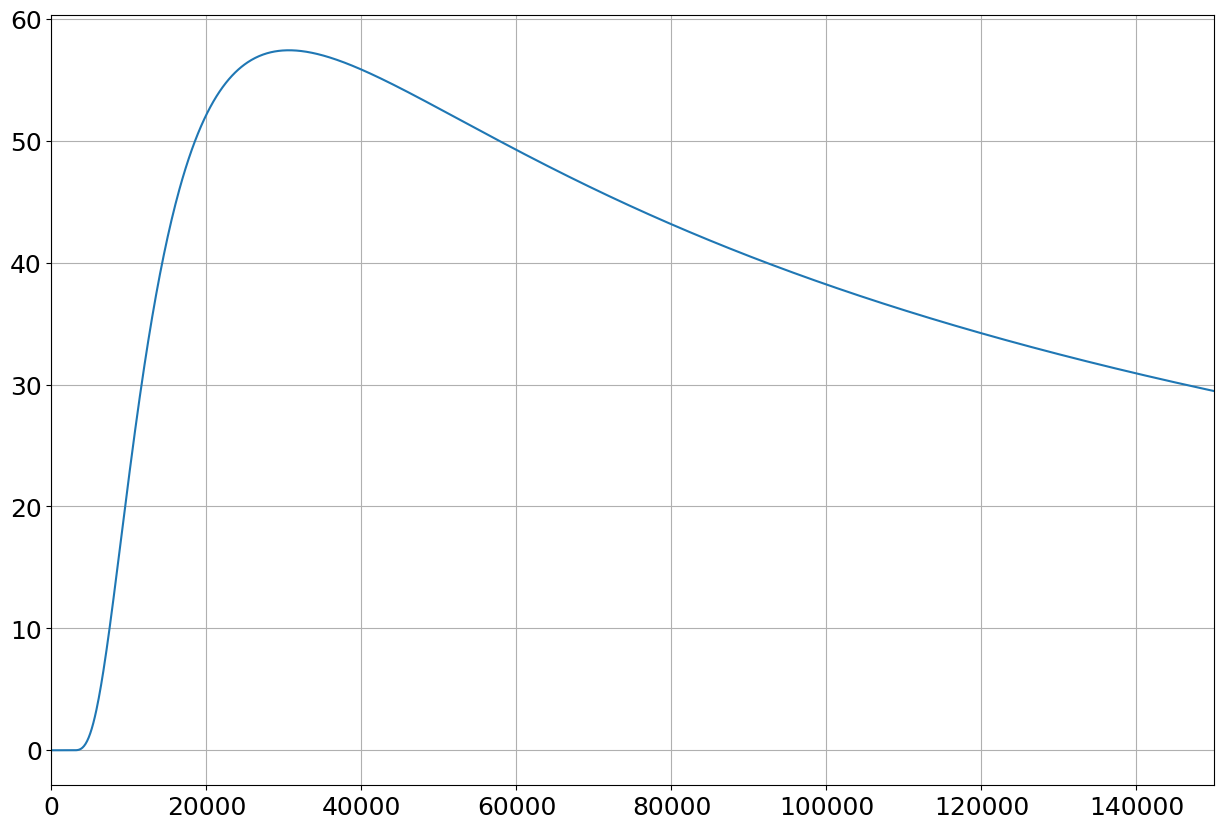

In [5]:
plt.plot(rs, V)
plt.grid()
plt.xlim(0, 150000)

In [6]:
### Apply K25
u_K25, v_K25 = kepert2025(THs, Rs, Vs, K, C, c1, c2, fcr, Zs, z_ref, h)
print('K25 applied.')

# Get polar dataset
kep_pol = get_xrDataset_polar(zs, ths, rs, u_K25, v_K25)
print('Polar dataset created.')

# Get cartesian dataset 
kep_car = get_xrDataset_cartesian(Xs, Ys, x_ref, y_ref, dim_ref, kep_pol)
print('Cartesian dataset created.')

# Get w
kep_pol, kep_car = get_w(kep_pol, kep_car, zs)
print('Vertical velocity estimated.')

K25 applied.
Polar dataset created.


  0%|          | 0/8 [00:00<?, ?it/s]

Cartesian dataset created.


  0%|          | 0/8 [00:00<?, ?it/s]

Vertical velocity estimated.


In [7]:
# Get drag coefficient
def drag_coefficient(THs, C, c1, c2, h):
    return C * (1 + c1 * np.cos(THs) + c2 * h * np.sin(THs))

cd = griddata((Xs[0, :, :].flatten(), Ys[0, :, :].flatten()), drag_coefficient(THs[0, :, :], C, c1, c2, h).flatten(),   (x_ref, y_ref), method='nearest')

#### Fig. 2 of K25

(-120000.0, 120000.0)

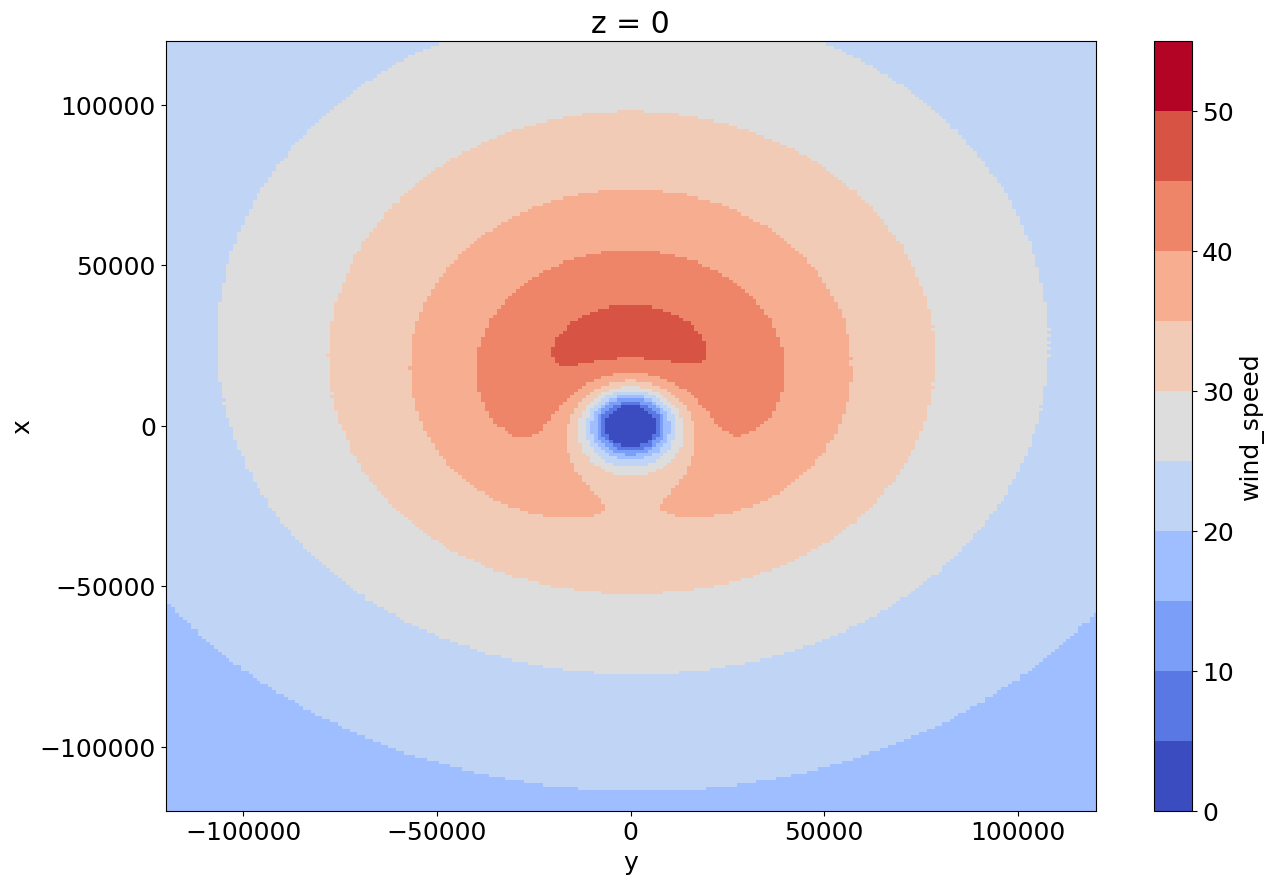

In [8]:
# (a)
cmap = plt.get_cmap('coolwarm', 11)

kep_car.sel(z=0).wind_speed.plot(cmap=cmap, vmin=0, vmax=55)

# Grid
plt.xlim(-120000, 120000)
plt.ylim(-120000, 120000)

(-120000.0, 120000.0)

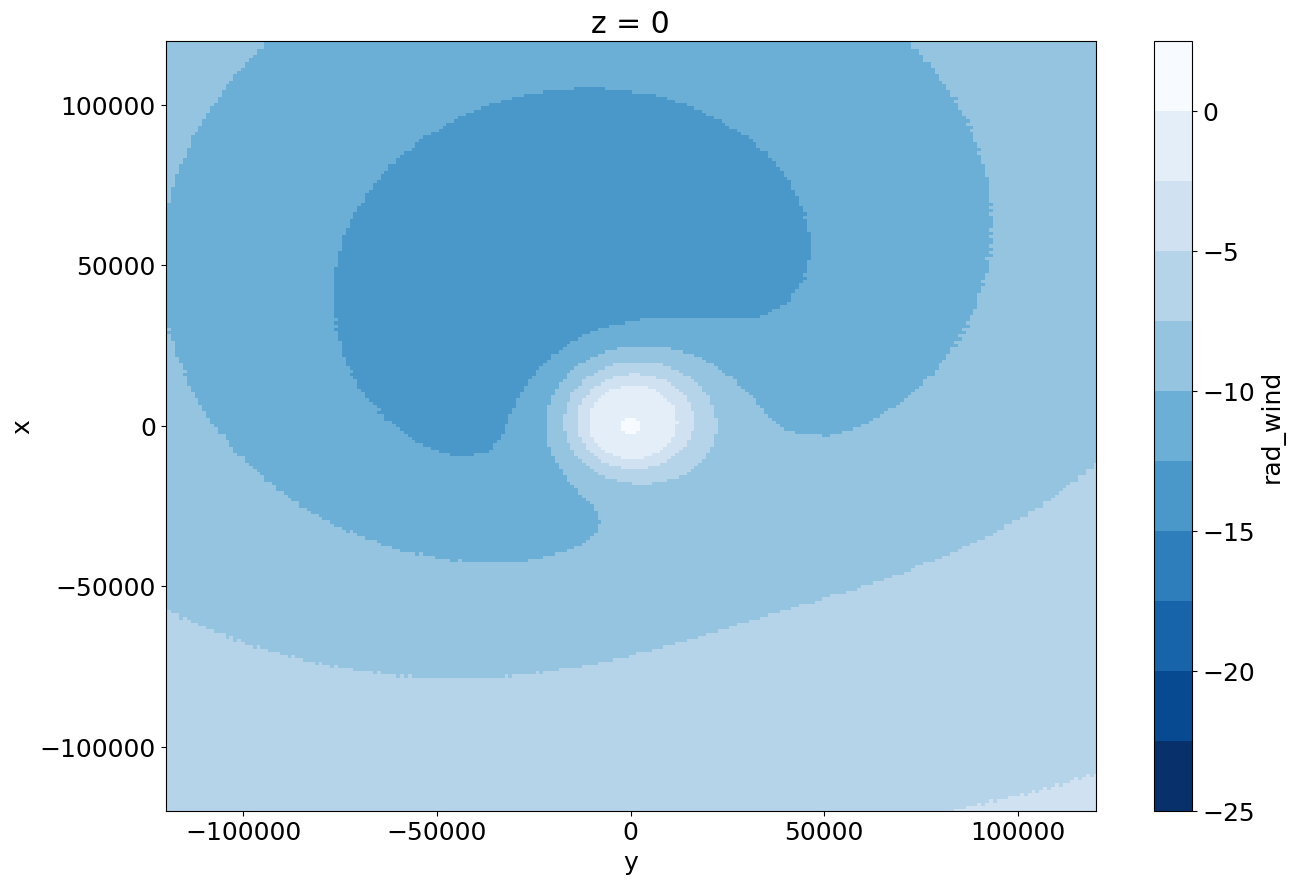

In [9]:
# (b)
cmap = plt.get_cmap('Blues_r', 11)

kep_car.sel(z=0).rad_wind.plot(cmap=cmap, vmin=-25, vmax=2.5)

# Grid
plt.xlim(-120000, 120000)
plt.ylim(-120000, 120000)

/tmp/ipykernel_8895/1544320824.py:6: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(x_ref, y_ref, np.array(kep_car.sel(z=1010).w), levels=[0, 0.1, 0.2, 0.3, 0.4], colors='k', linewidth=3)


(-120000.0, 120000.0)

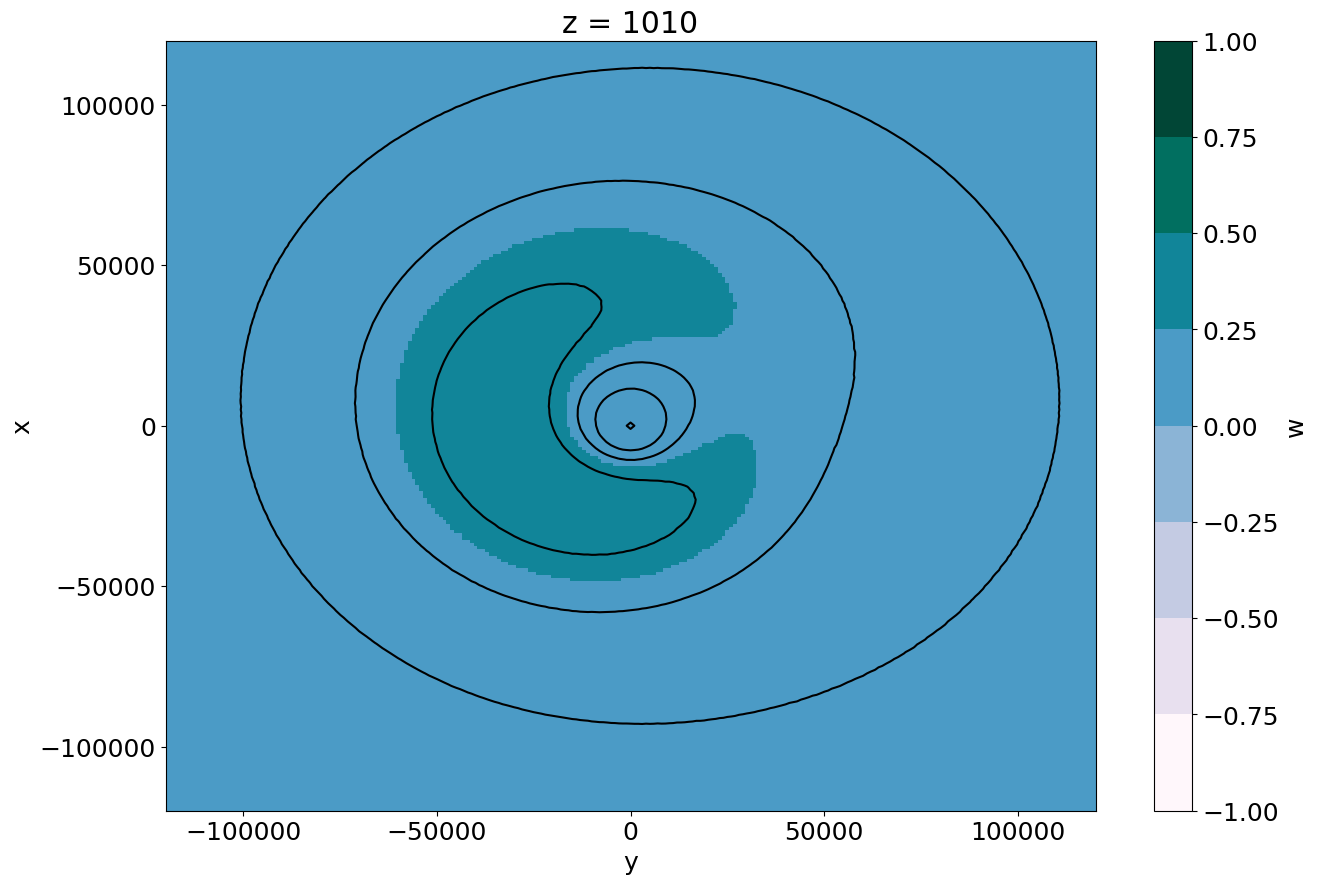

In [10]:
# (c)
# TODO: K25 est en échelle log
cmap = plt.get_cmap('PuBuGn', 8)

kep_car.sel(z=1010).w.plot(cmap=cmap, vmin=-1, vmax=1)
plt.contour(x_ref, y_ref, np.array(kep_car.sel(z=1010).w), levels=[0, 0.1, 0.2, 0.3, 0.4], colors='k', linewidth=3)

# Grid
plt.xlim(-120000, 120000)
plt.ylim(-120000, 120000)

/tmp/ipykernel_8895/953826080.py:5: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(x_ref, y_ref, -np.array(kep_car.sel(z=0).inflow_angle), levels=[-25, -20, -15, -10, -5], colors='tab:blue', linewidth=3)


(-120000.0, 120000.0)

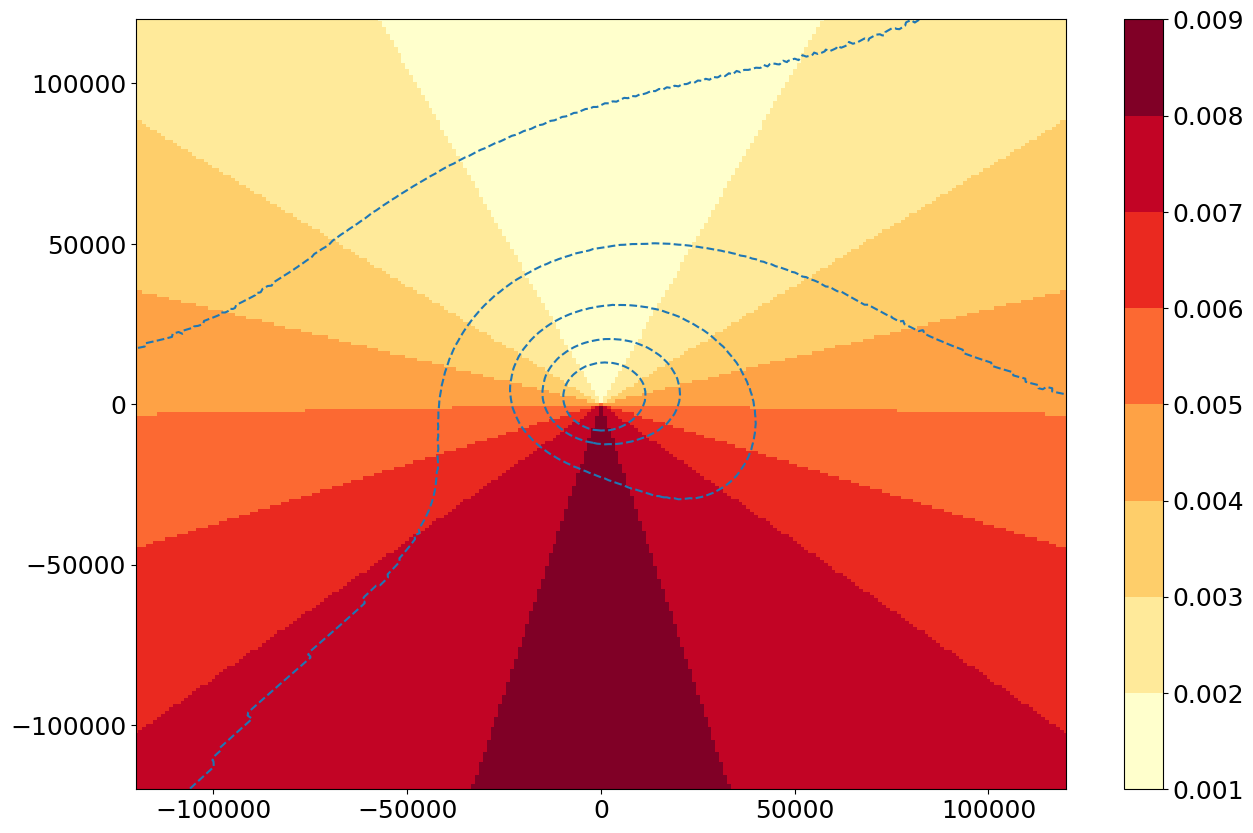

In [12]:
# (d)
cmap = plt.get_cmap('YlOrRd', 8)

im   = plt.pcolormesh(x_ref, y_ref, cd, vmin=1e-3, vmax=9e-3, cmap=cmap)
plt.contour(x_ref, y_ref, -np.array(kep_car.sel(z=0).inflow_angle), levels=[-25, -20, -15, -10, -5], colors='tab:blue', linewidth=3)
plt.colorbar(im)

# Grid
plt.xlim(-120000, 120000)
plt.ylim(-120000, 120000)

#### Fig. 3

(-120000.0, 120000.0)

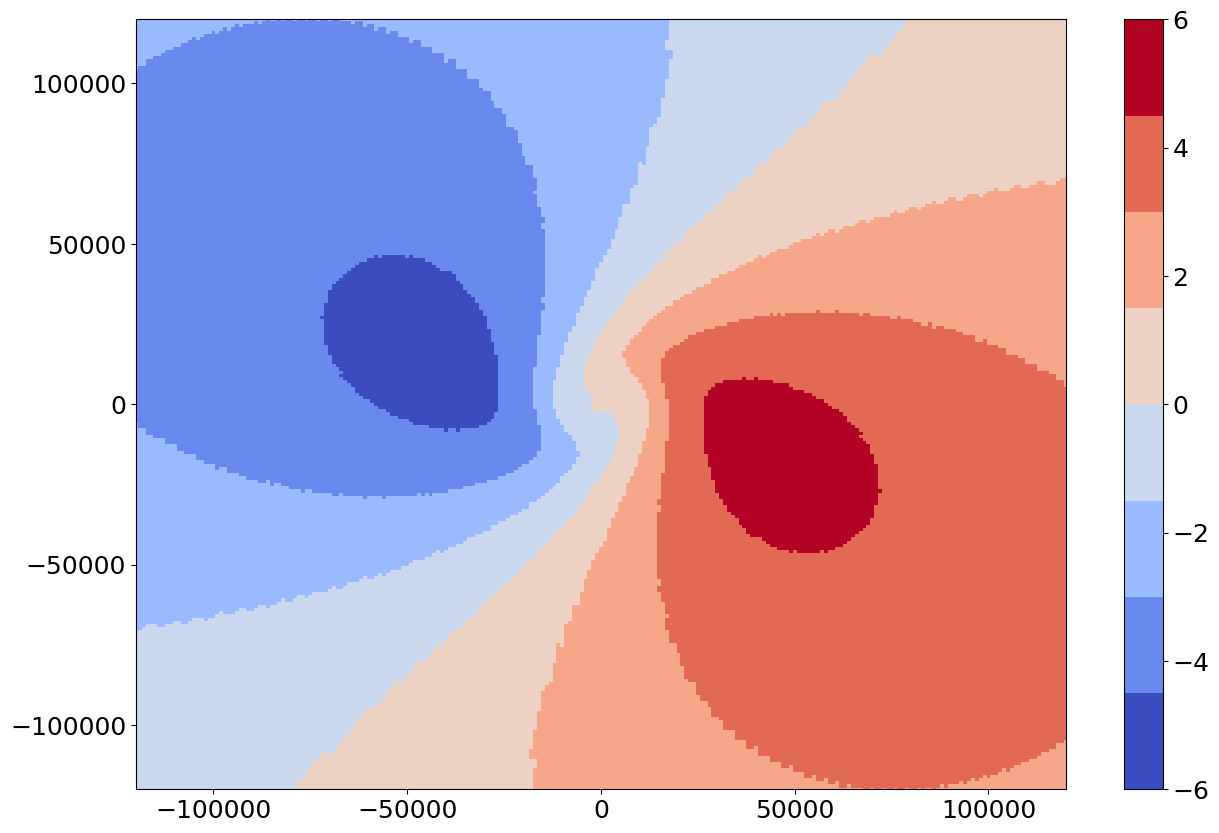

In [33]:
# (a)
cmap = plt.get_cmap('coolwarm', 8)

var  = griddata((Xs[:1, :, :].flatten(), Ys[:1, :, :].flatten()), u_1(THs[:1, :, :], Rs[:1, :, :], Vs[:1, :, :], K, C, c1, c2, fcr, z_ref, z_ref, h).flatten(),   (x_ref, y_ref), method='nearest')

plt.pcolormesh(x_ref, y_ref, var, cmap=cmap, vmin=-6, vmax=6)
plt.colorbar()

# Grid
plt.xlim(-120000, 120000)
plt.ylim(-120000, 120000)

(-120000.0, 120000.0)

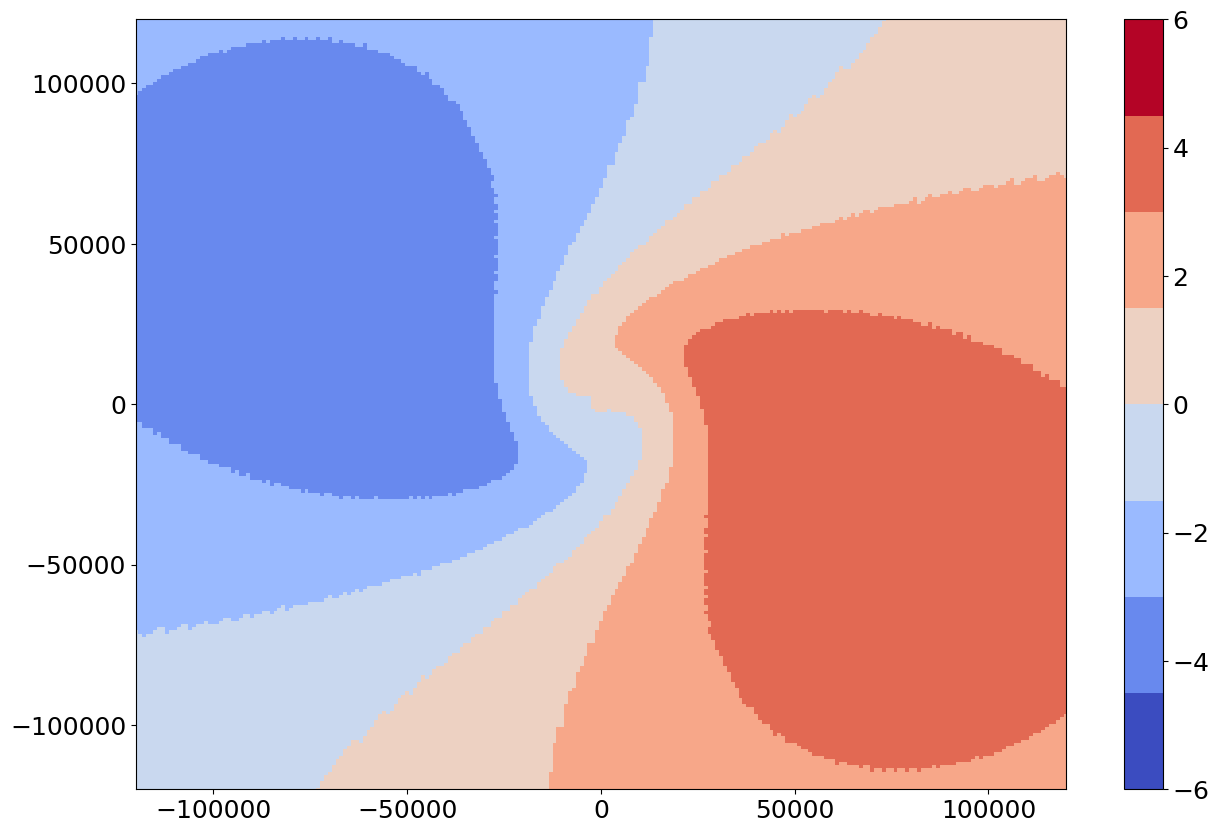

In [34]:
# (b)
cmap = plt.get_cmap('coolwarm', 8)

var  = griddata((Xs[:1, :, :].flatten(), Ys[:1, :, :].flatten()), u_1(THs[:1, :, :], Rs[:1, :, :], Vs[:1, :, :], K, C, c1, c2, fcr, 100 + z_ref, z_ref, h).flatten(),   (x_ref, y_ref), method='nearest')

plt.pcolormesh(x_ref, y_ref, var, cmap=cmap, vmin=-6, vmax=6)
plt.colorbar()

# Grid
plt.xlim(-120000, 120000)
plt.ylim(-120000, 120000)

(-120000.0, 120000.0)

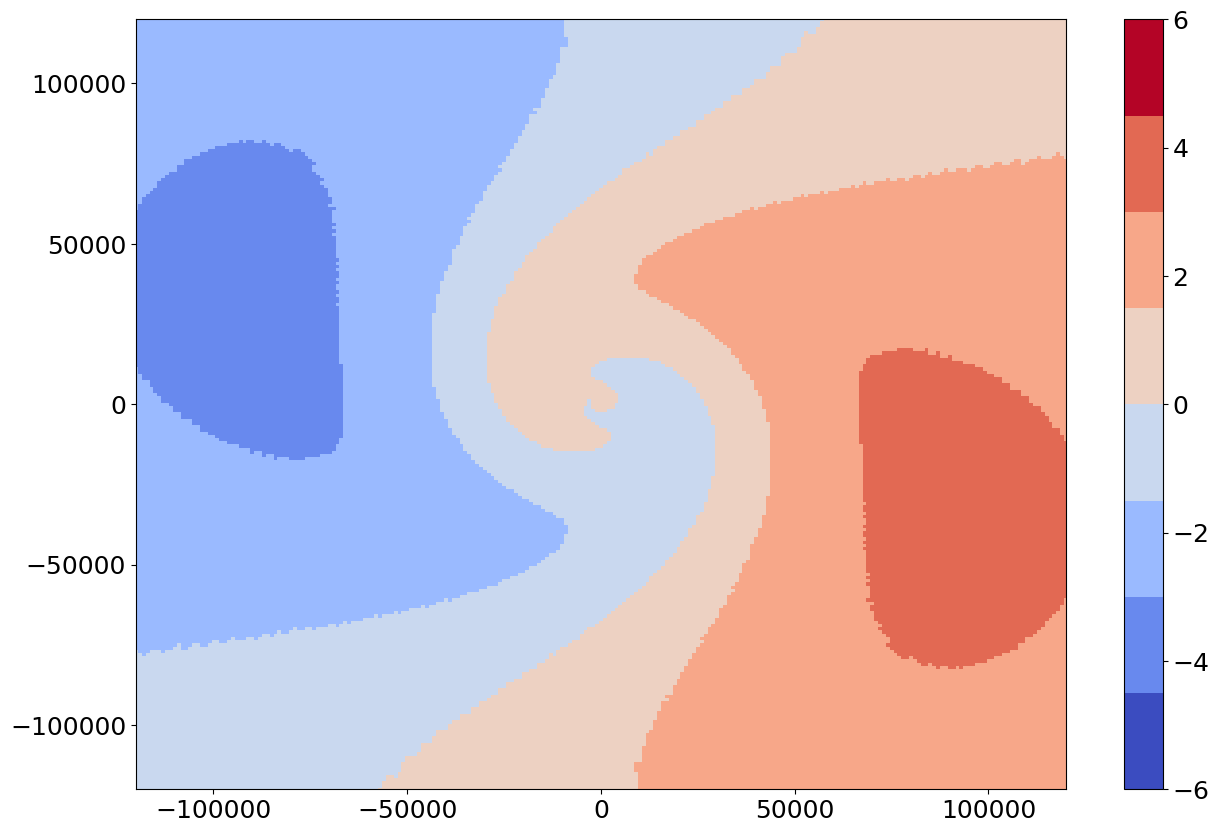

In [35]:
# (c)
cmap = plt.get_cmap('coolwarm', 8)

var  = griddata((Xs[:1, :, :].flatten(), Ys[:1, :, :].flatten()), u_1(THs[:1, :, :], Rs[:1, :, :], Vs[:1, :, :], K, C, c1, c2, fcr, 500 + z_ref, z_ref, h).flatten(),   (x_ref, y_ref), method='nearest')

plt.pcolormesh(x_ref, y_ref, var, cmap=cmap, vmin=-6, vmax=6)
plt.colorbar()

# Grid
plt.xlim(-120000, 120000)
plt.ylim(-120000, 120000)

(-120000.0, 120000.0)

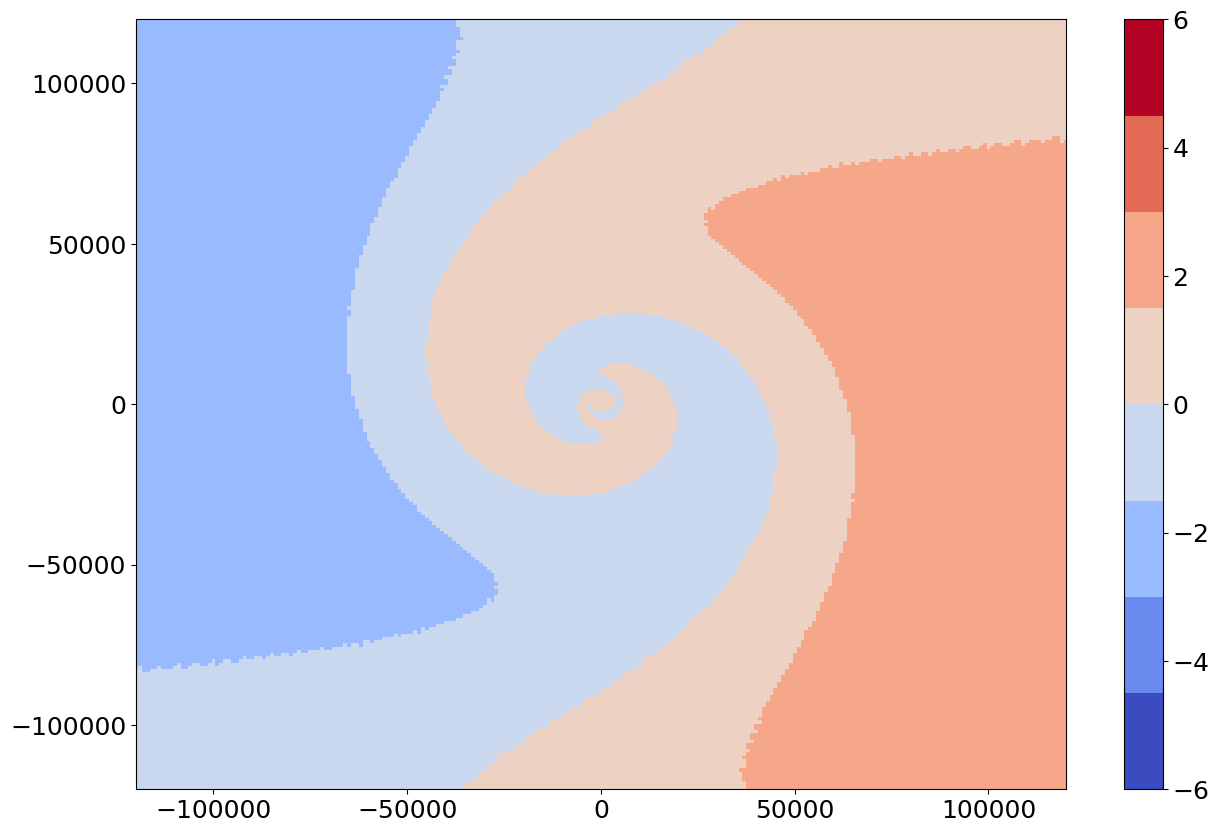

In [36]:
# (d)
cmap = plt.get_cmap('coolwarm', 8)

var  = griddata((Xs[:1, :, :].flatten(), Ys[:1, :, :].flatten()), u_1(THs[:1, :, :], Rs[:1, :, :], Vs[:1, :, :], K, C, c1, c2, fcr, 1000 + z_ref, z_ref, h).flatten(),   (x_ref, y_ref), method='nearest')

plt.pcolormesh(x_ref, y_ref, var, cmap=cmap, vmin=-6, vmax=6)
plt.colorbar()

# Grid
plt.xlim(-120000, 120000)
plt.ylim(-120000, 120000)

(-120000.0, 120000.0)

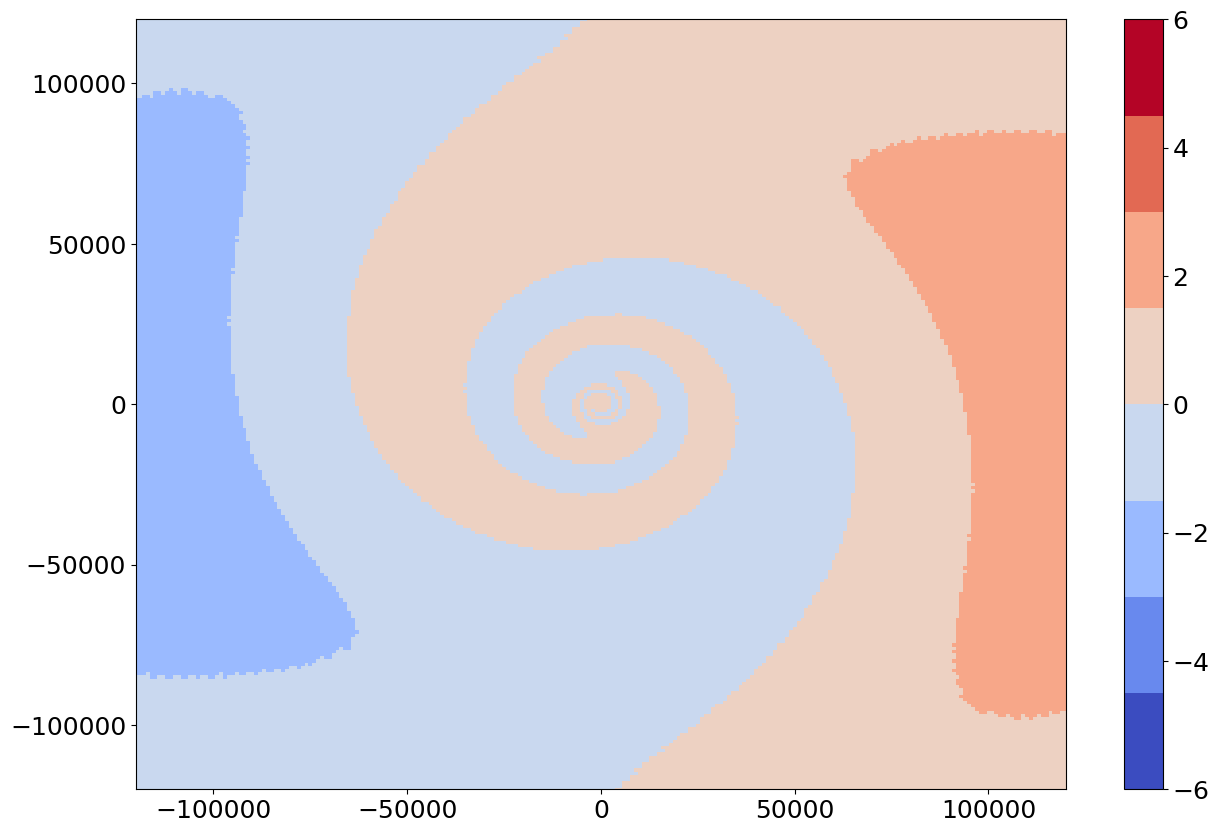

In [37]:
# (e)
cmap = plt.get_cmap('coolwarm', 8)

var  = griddata((Xs[:1, :, :].flatten(), Ys[:1, :, :].flatten()), u_1(THs[:1, :, :], Rs[:1, :, :], Vs[:1, :, :], K, C, c1, c2, fcr, 2000 + z_ref, z_ref, h).flatten(),   (x_ref, y_ref), method='nearest')

plt.pcolormesh(x_ref, y_ref, var, cmap=cmap, vmin=-6, vmax=6)
plt.colorbar()

# Grid
plt.xlim(-120000, 120000)
plt.ylim(-120000, 120000)

(-120000.0, 120000.0)

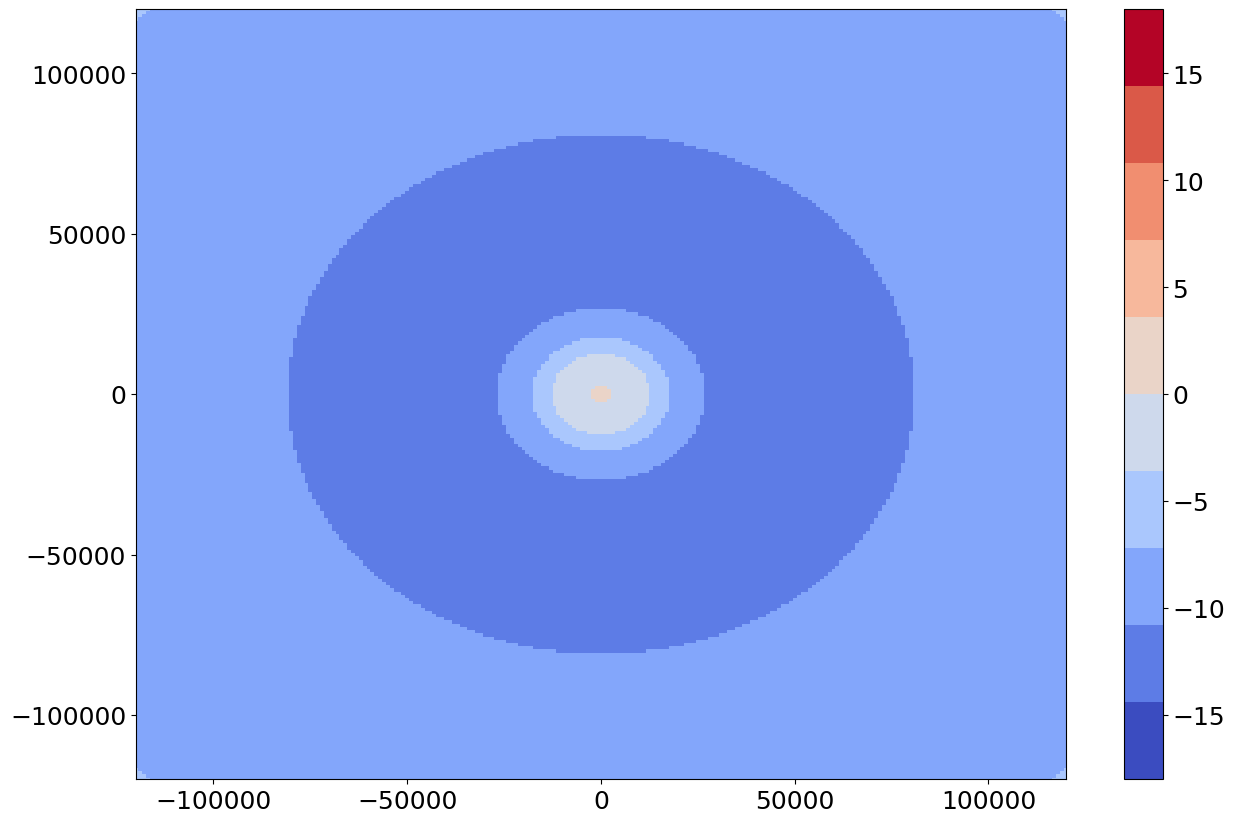

In [38]:
# (f)
cmap = plt.get_cmap('coolwarm', 10)

var  = griddata((Xs[:1, :, :].flatten(), Ys[:1, :, :].flatten()), u0(Rs[:1, :, :], Vs[:1, :, :], K, C, fcr, z_ref, z_ref).flatten(), (x_ref, y_ref), method='nearest')

plt.pcolormesh(x_ref, y_ref, var, cmap=cmap, vmin=-18, vmax=18)
plt.colorbar()

# Grid
plt.xlim(-120000, 120000)
plt.ylim(-120000, 120000)

(-120000.0, 120000.0)

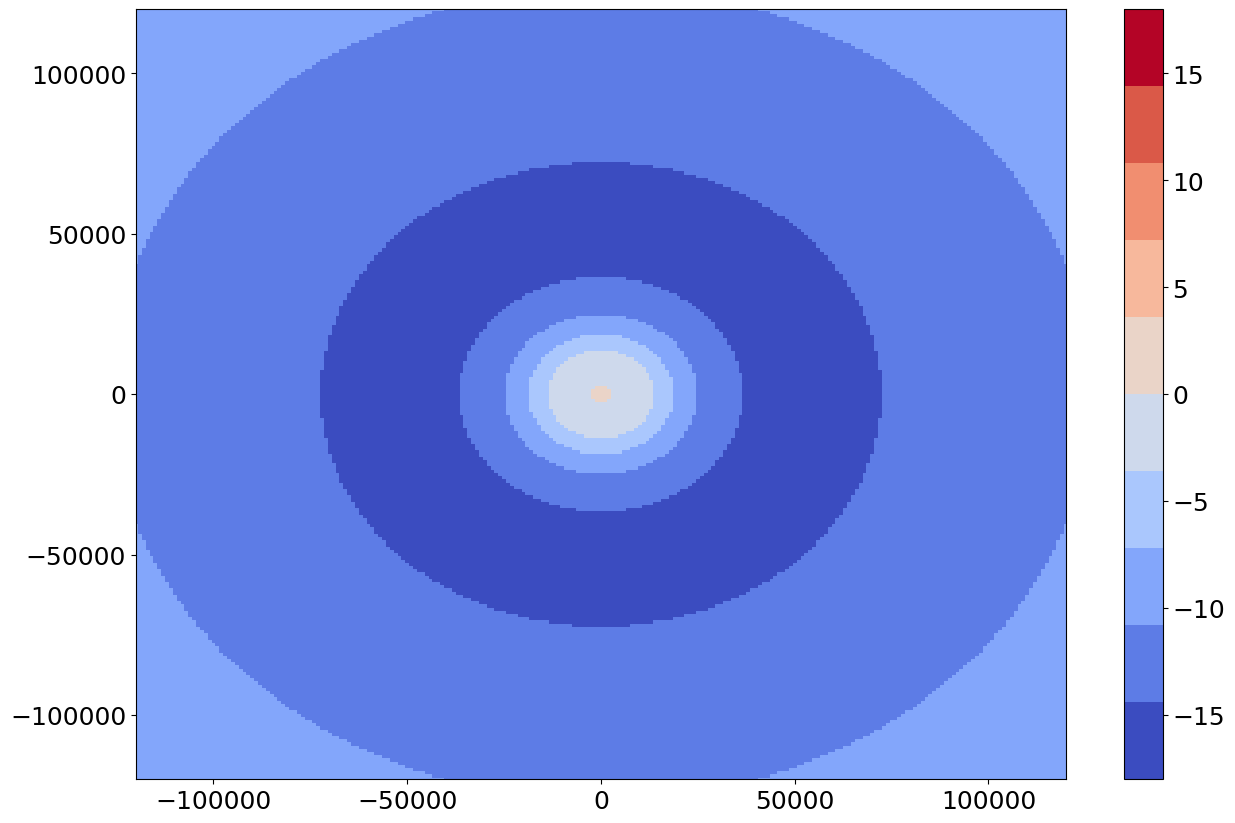

In [39]:
# (g)
cmap = plt.get_cmap('coolwarm', 10)

var  = griddata((Xs[:1, :, :].flatten(), Ys[:1, :, :].flatten()), u0(Rs[:1, :, :], Vs[:1, :, :], K, C, fcr, 100 + z_ref, z_ref).flatten(), (x_ref, y_ref), method='nearest')

plt.pcolormesh(x_ref, y_ref, var, cmap=cmap, vmin=-18, vmax=18)
plt.colorbar()

# Grid
plt.xlim(-120000, 120000)
plt.ylim(-120000, 120000)

(-120000.0, 120000.0)

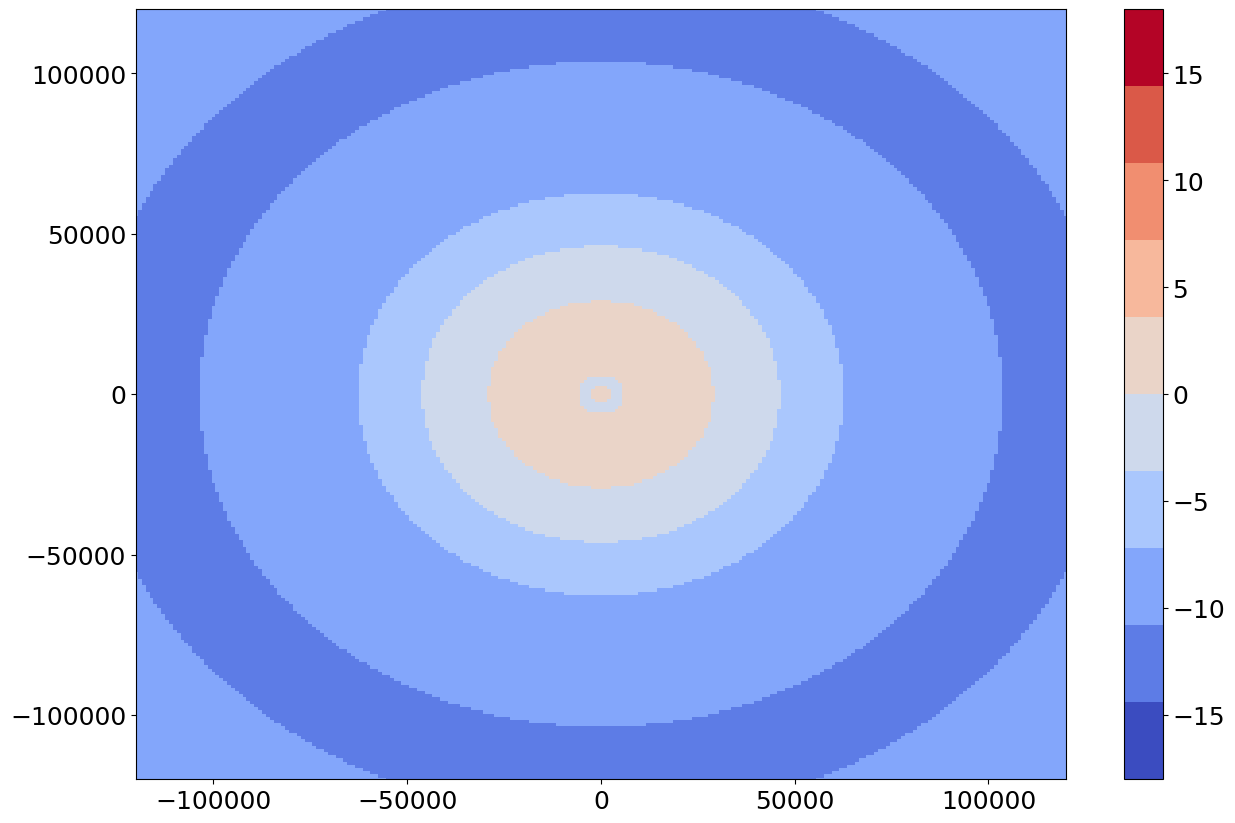

In [40]:
# (h)
cmap = plt.get_cmap('coolwarm', 10)

var  = griddata((Xs[:1, :, :].flatten(), Ys[:1, :, :].flatten()), u0(Rs[:1, :, :], Vs[:1, :, :], K, C, fcr, 500 + z_ref, z_ref).flatten(), (x_ref, y_ref), method='nearest')

plt.pcolormesh(x_ref, y_ref, var, cmap=cmap, vmin=-18, vmax=18)
plt.colorbar()

# Grid
plt.xlim(-120000, 120000)
plt.ylim(-120000, 120000)

(-120000.0, 120000.0)

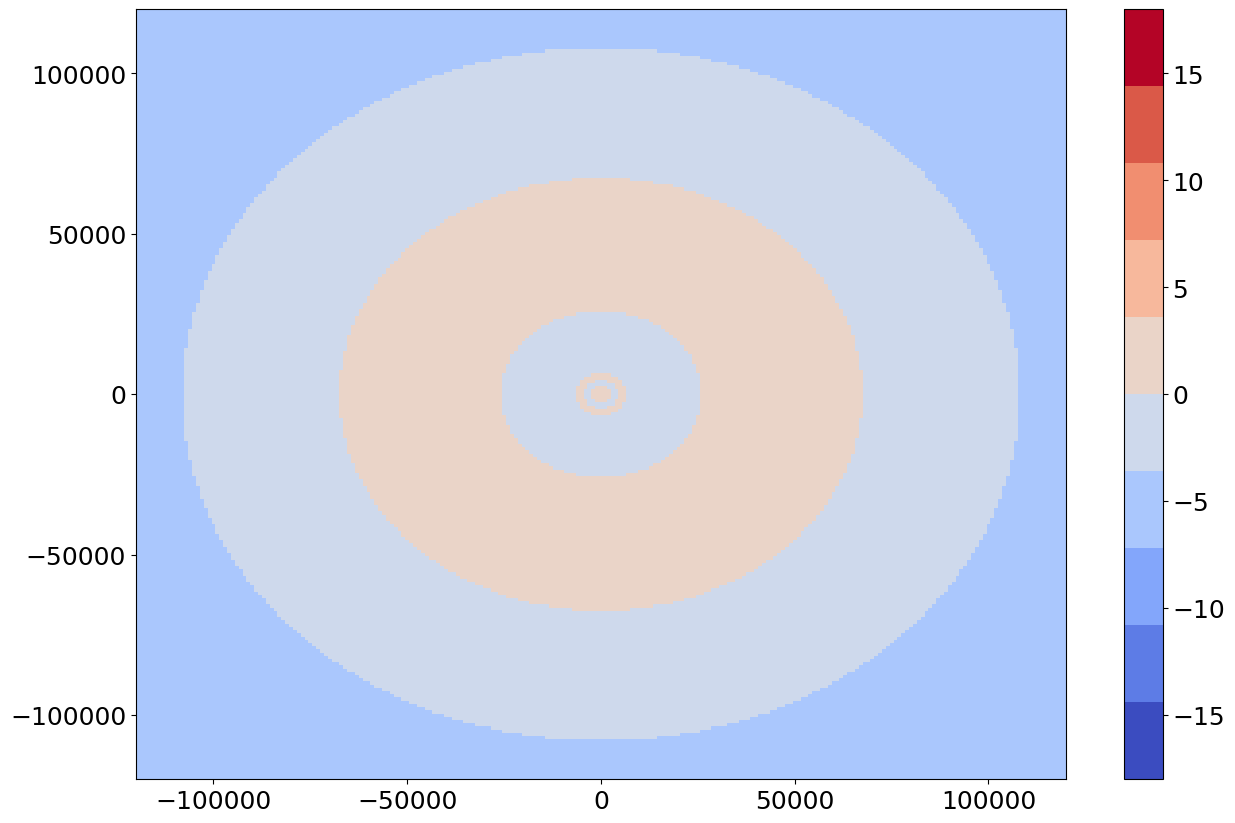

In [41]:
# (i)
cmap = plt.get_cmap('coolwarm', 10)

var  = griddata((Xs[:1, :, :].flatten(), Ys[:1, :, :].flatten()), u0(Rs[:1, :, :], Vs[:1, :, :], K, C, fcr, 1000 + z_ref, z_ref).flatten(), (x_ref, y_ref), method='nearest')

plt.pcolormesh(x_ref, y_ref, var, cmap=cmap, vmin=-18, vmax=18)
plt.colorbar()

# Grid
plt.xlim(-120000, 120000)
plt.ylim(-120000, 120000)

(-120000.0, 120000.0)

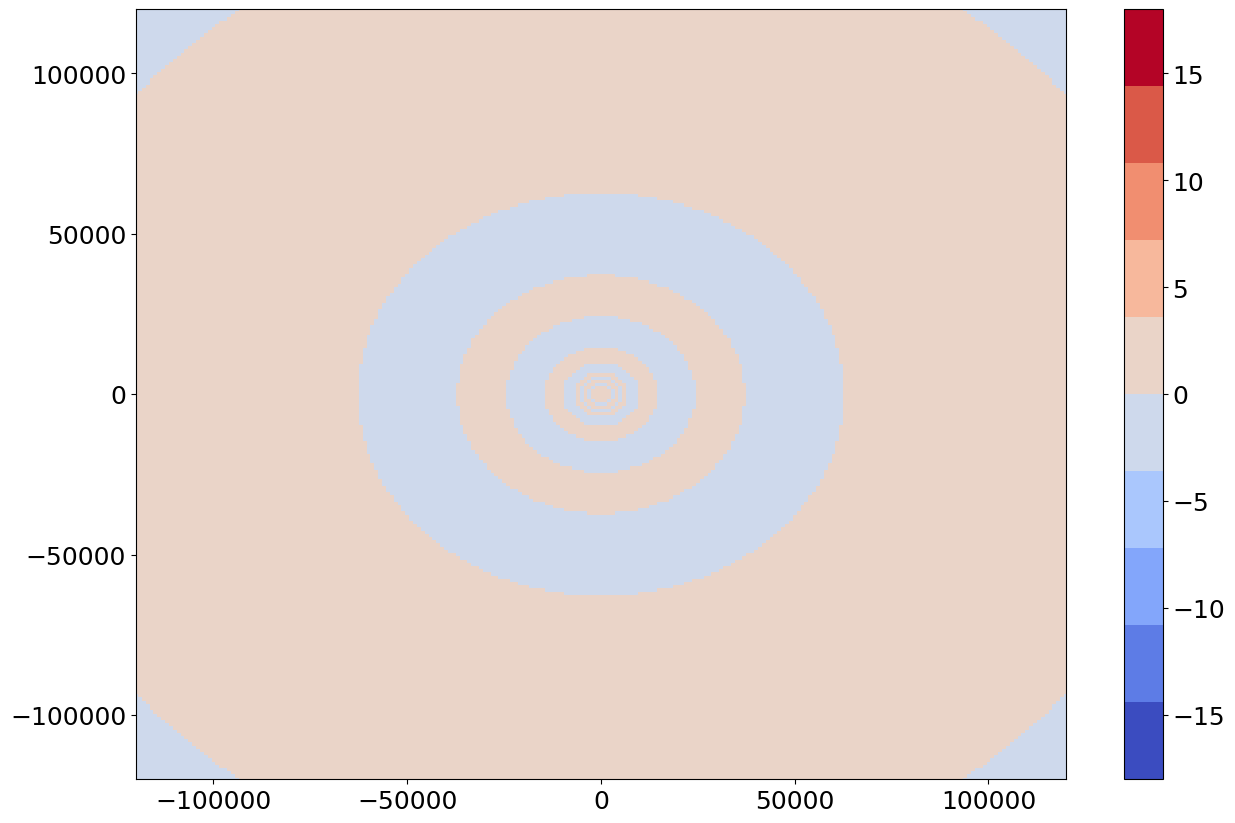

In [42]:
# (j)
cmap = plt.get_cmap('coolwarm', 10)

var  = griddata((Xs[:1, :, :].flatten(), Ys[:1, :, :].flatten()), u0(Rs[:1, :, :], Vs[:1, :, :], K, C, fcr, 2000 + z_ref, z_ref).flatten(), (x_ref, y_ref), method='nearest')

plt.pcolormesh(x_ref, y_ref, var, cmap=cmap, vmin=-18, vmax=18)
plt.colorbar()

# Grid
plt.xlim(-120000, 120000)
plt.ylim(-120000, 120000)

(-120000.0, 120000.0)

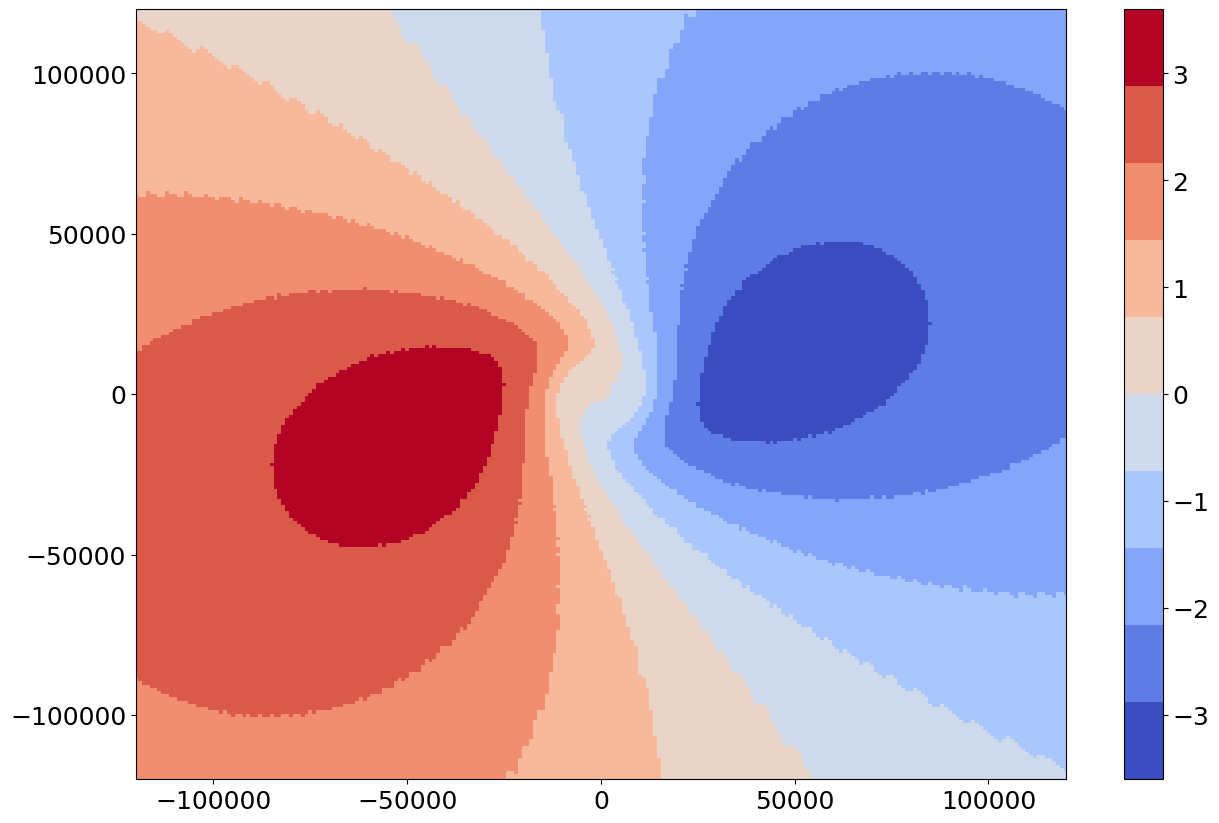

In [44]:
# (k)
cmap = plt.get_cmap('coolwarm', 10)

var  = griddata((Xs[:1, :, :].flatten(), Ys[:1, :, :].flatten()), u1(THs[:1, :, :], Rs[:1, :, :], Vs[:1, :, :], K, C, c1, c2, fcr, z_ref, z_ref, h).flatten(),   (x_ref, y_ref), method='nearest')

plt.pcolormesh(x_ref, y_ref, var, cmap=cmap, vmin=-3.6, vmax=3.6)
plt.colorbar()

# Grid
plt.xlim(-120000, 120000)
plt.ylim(-120000, 120000)

(-120000.0, 120000.0)

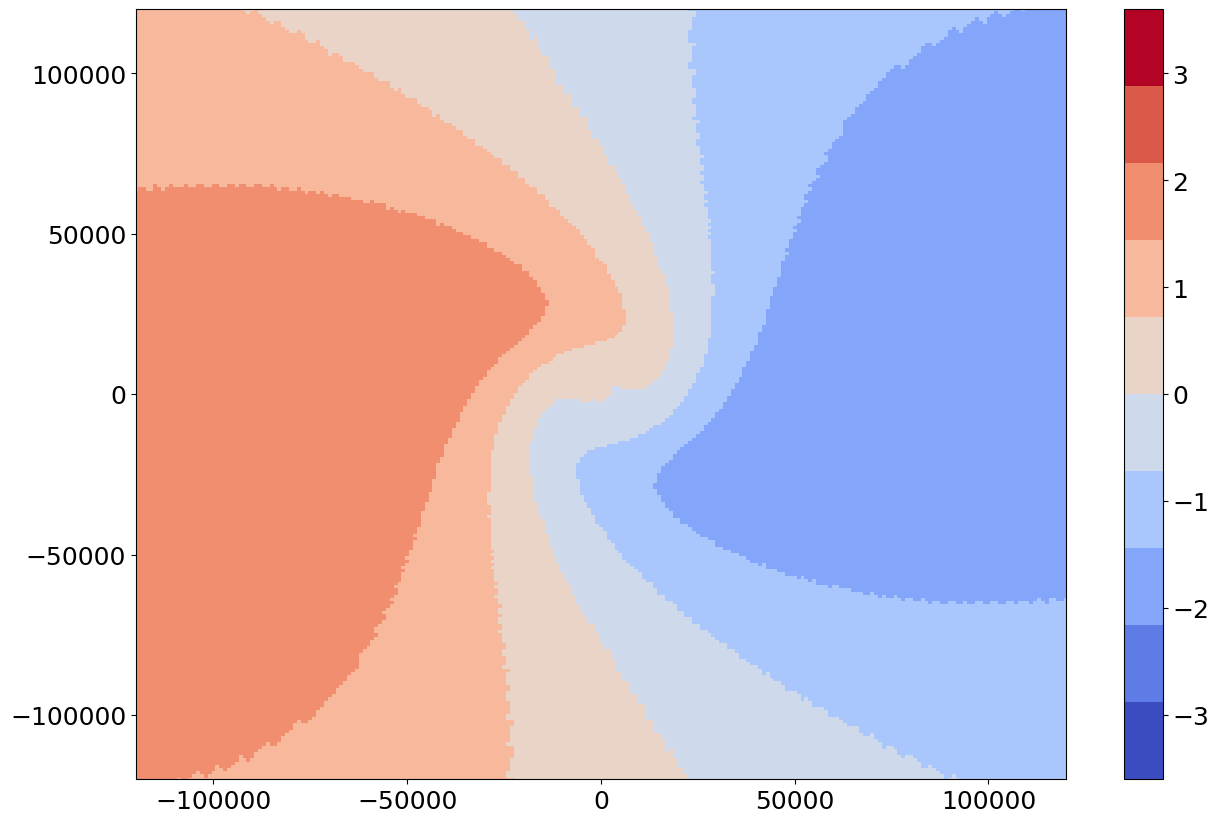

In [45]:
# (l)
cmap = plt.get_cmap('coolwarm', 10)

var  = griddata((Xs[:1, :, :].flatten(), Ys[:1, :, :].flatten()), u1(THs[:1, :, :], Rs[:1, :, :], Vs[:1, :, :], K, C, c1, c2, fcr, 100 + z_ref, z_ref, h).flatten(),   (x_ref, y_ref), method='nearest')

plt.pcolormesh(x_ref, y_ref, var, cmap=cmap, vmin=-3.6, vmax=3.6)
plt.colorbar()

# Grid
plt.xlim(-120000, 120000)
plt.ylim(-120000, 120000)

(-120000.0, 120000.0)

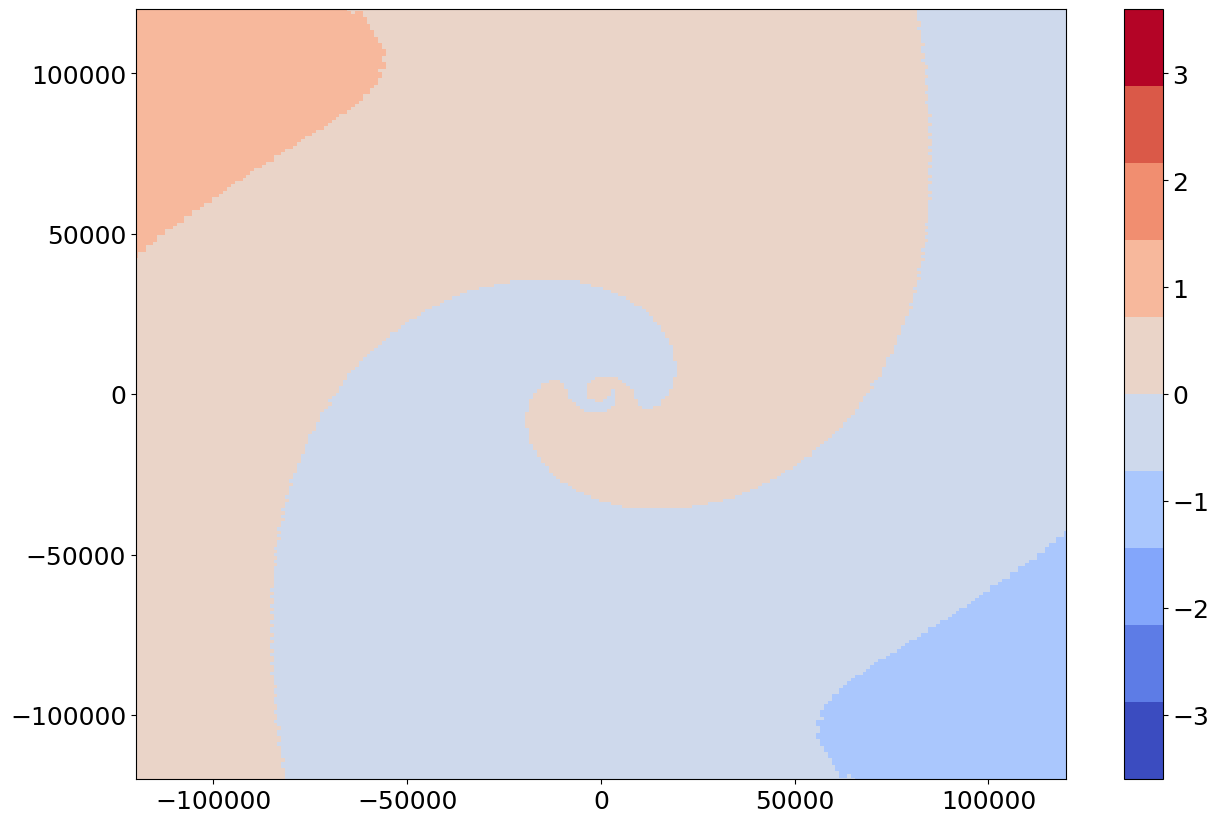

In [46]:
# (m)
cmap = plt.get_cmap('coolwarm', 10)

var  = griddata((Xs[:1, :, :].flatten(), Ys[:1, :, :].flatten()), u1(THs[:1, :, :], Rs[:1, :, :], Vs[:1, :, :], K, C, c1, c2, fcr, 500 + z_ref, z_ref, h).flatten(),   (x_ref, y_ref), method='nearest')

plt.pcolormesh(x_ref, y_ref, var, cmap=cmap, vmin=-3.6, vmax=3.6)
plt.colorbar()

# Grid
plt.xlim(-120000, 120000)
plt.ylim(-120000, 120000)

(-120000.0, 120000.0)

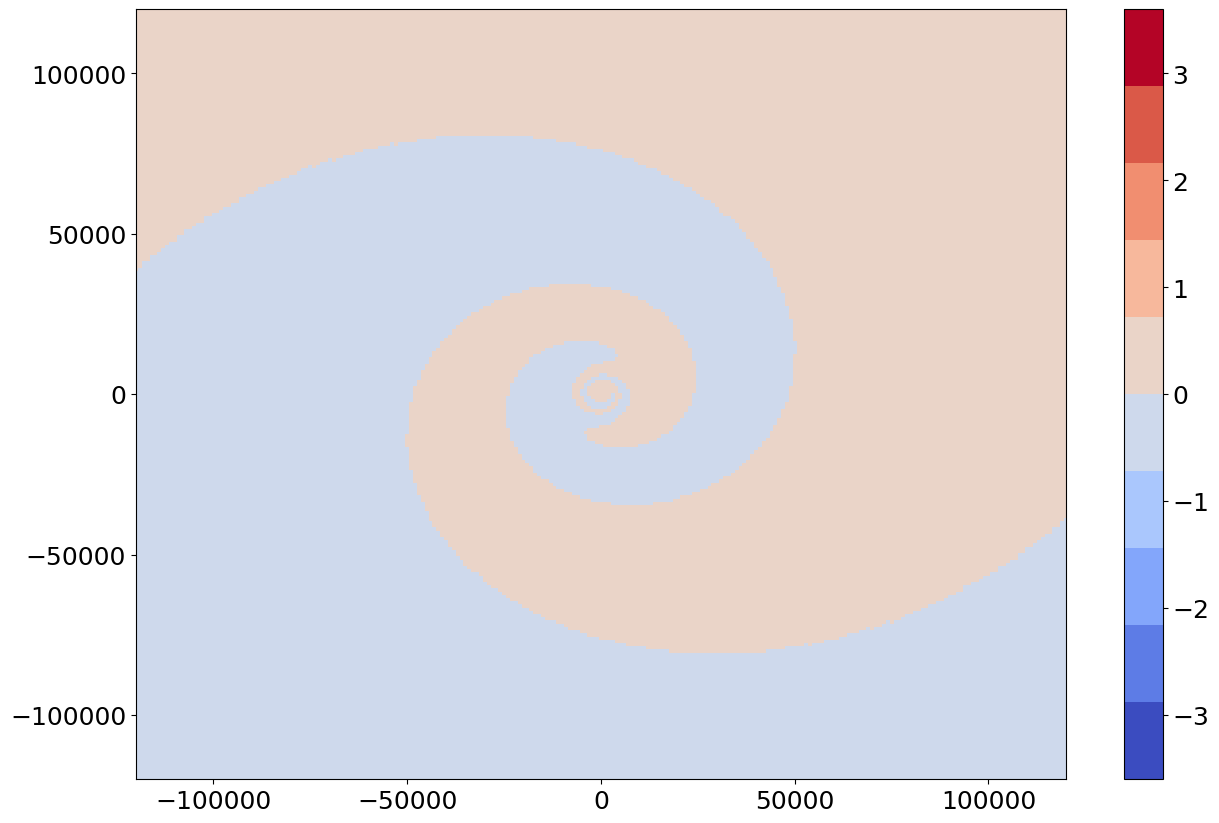

In [47]:
# (n)
cmap = plt.get_cmap('coolwarm', 10)

var  = griddata((Xs[:1, :, :].flatten(), Ys[:1, :, :].flatten()), u1(THs[:1, :, :], Rs[:1, :, :], Vs[:1, :, :], K, C, c1, c2, fcr, 1000 + z_ref, z_ref, h).flatten(),   (x_ref, y_ref), method='nearest')

plt.pcolormesh(x_ref, y_ref, var, cmap=cmap, vmin=-3.6, vmax=3.6)
plt.colorbar()

# Grid
plt.xlim(-120000, 120000)
plt.ylim(-120000, 120000)

(-120000.0, 120000.0)

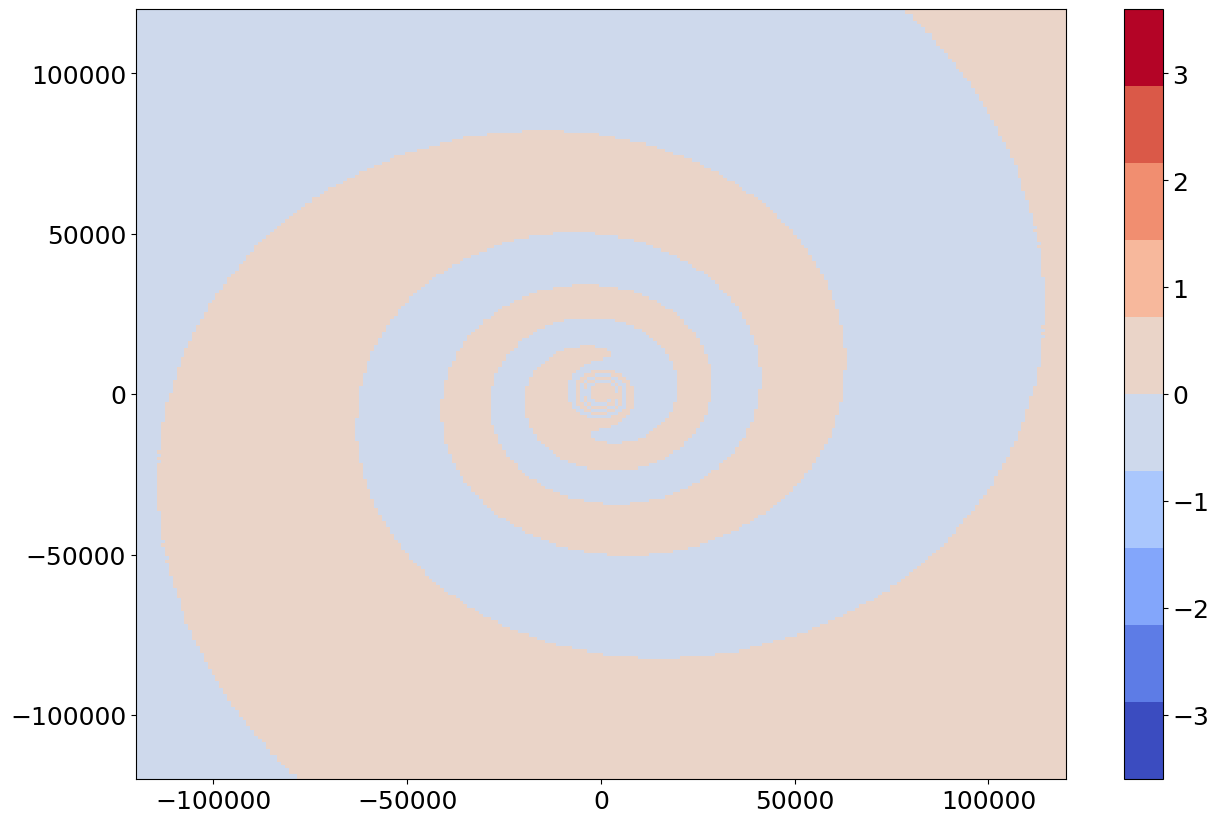

In [48]:
# (o)
cmap = plt.get_cmap('coolwarm', 10)

var  = griddata((Xs[:1, :, :].flatten(), Ys[:1, :, :].flatten()), u1(THs[:1, :, :], Rs[:1, :, :], Vs[:1, :, :], K, C, c1, c2, fcr, 2000 + z_ref, z_ref, h).flatten(),   (x_ref, y_ref), method='nearest')

plt.pcolormesh(x_ref, y_ref, var, cmap=cmap, vmin=-3.6, vmax=3.6)
plt.colorbar()

# Grid
plt.xlim(-120000, 120000)
plt.ylim(-120000, 120000)

(-120000.0, 120000.0)

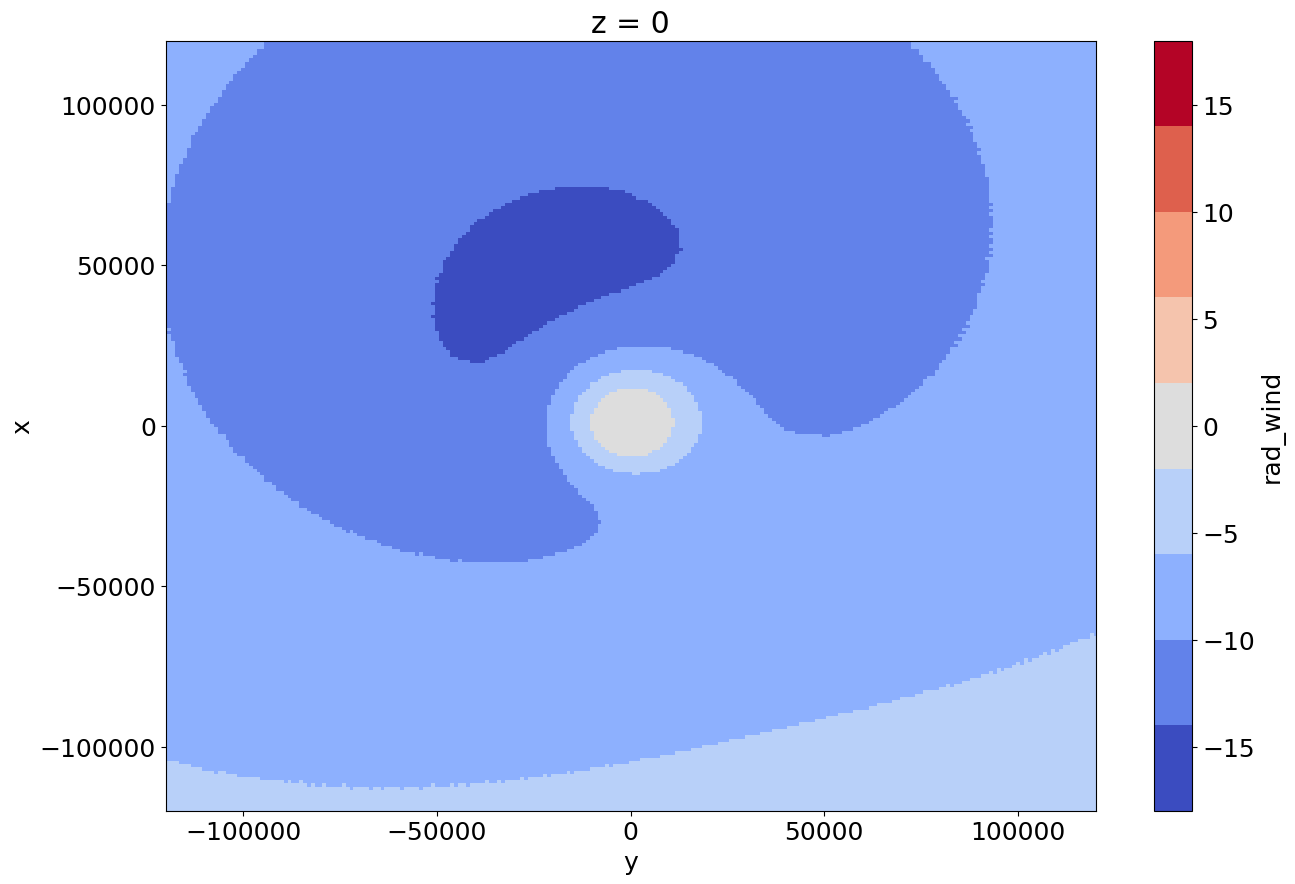

In [49]:
# (p)
cmap = plt.get_cmap('coolwarm', 9)

kep_car.sel(z=0).rad_wind.plot(cmap=cmap, vmin=-18, vmax=18)

# Grid
plt.xlim(-120000, 120000)
plt.ylim(-120000, 120000)

(-120000.0, 120000.0)

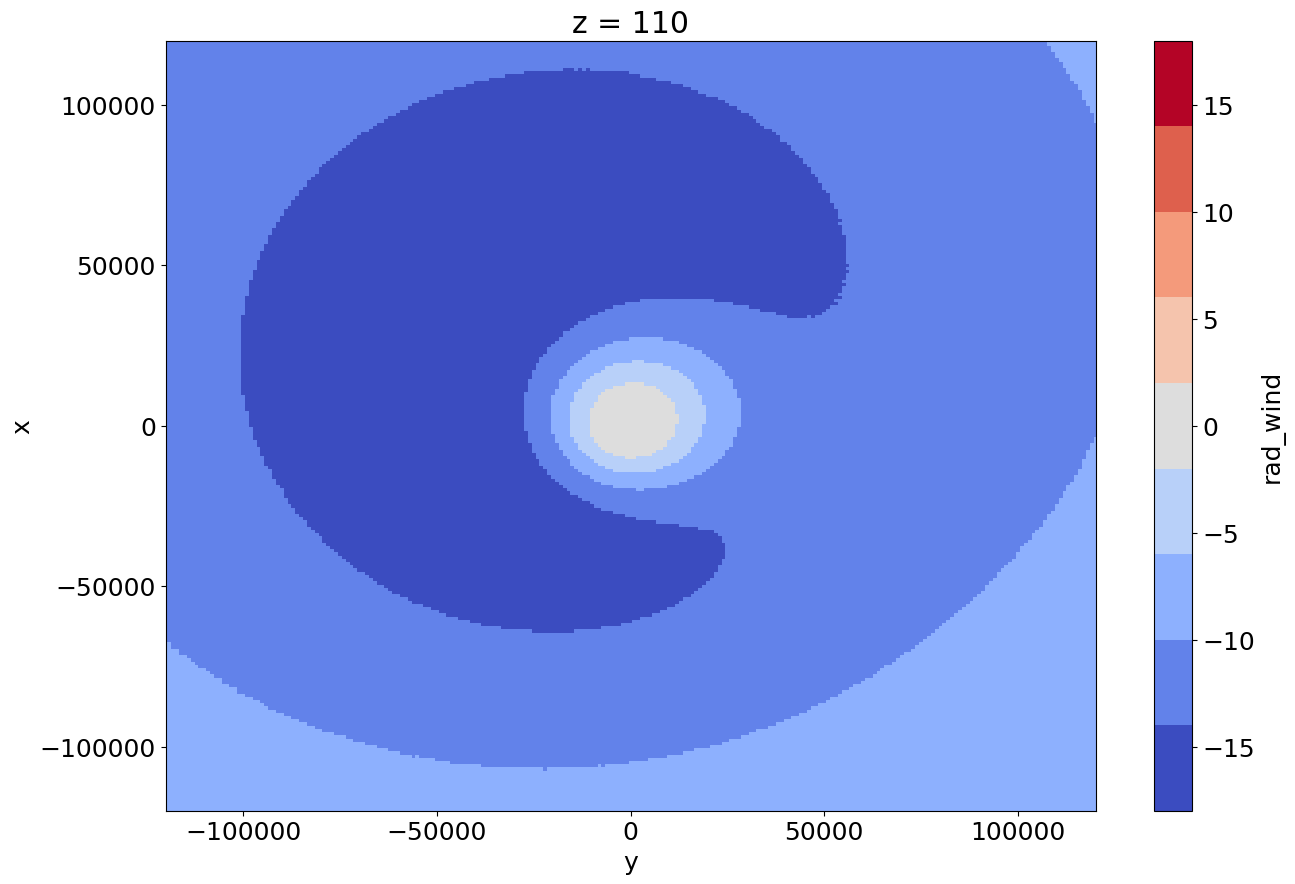

In [50]:
# (q)
cmap = plt.get_cmap('coolwarm', 9)

kep_car.sel(z=110).rad_wind.plot(cmap=cmap, vmin=-18, vmax=18)

# Grid
plt.xlim(-120000, 120000)
plt.ylim(-120000, 120000)

(-120000.0, 120000.0)

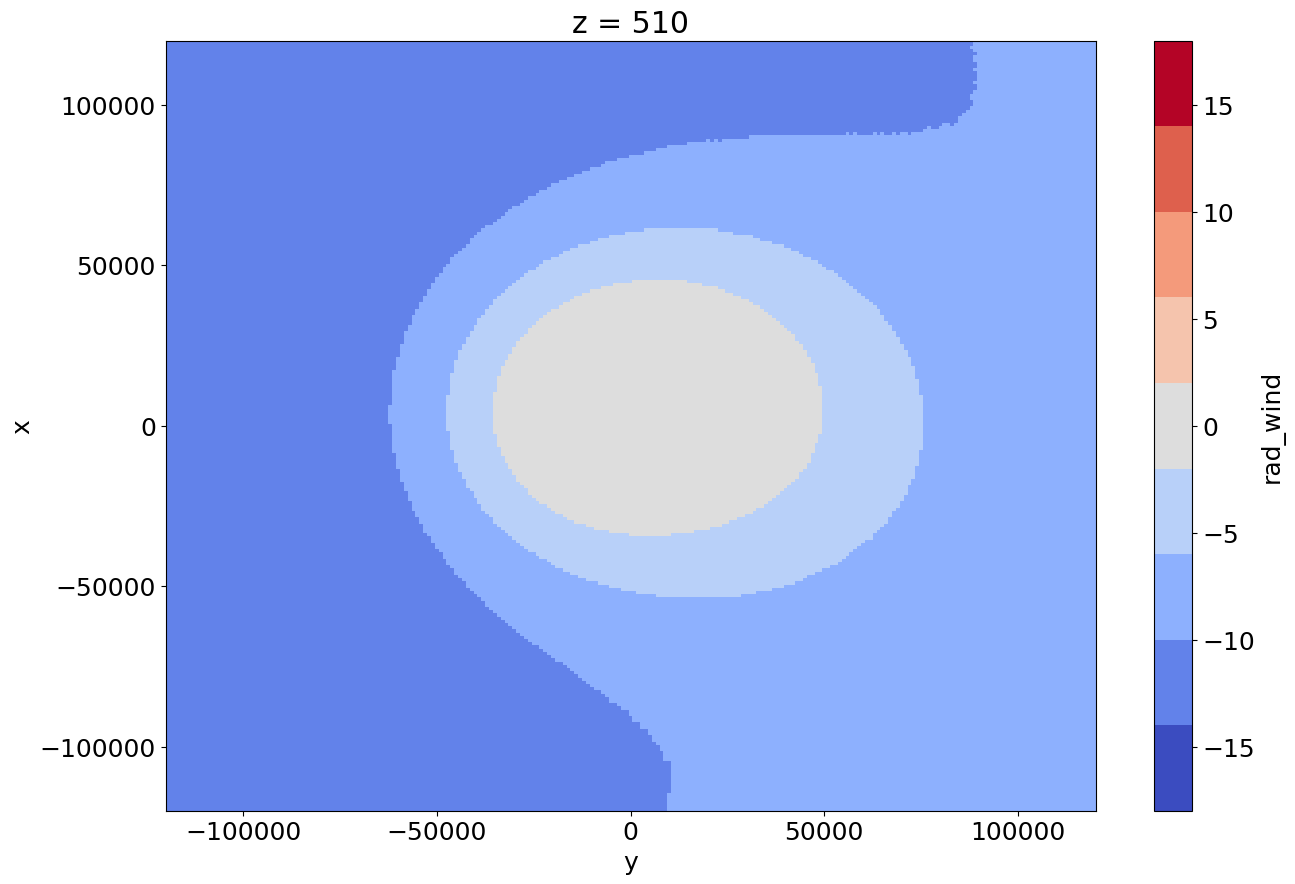

In [51]:
# (r)
cmap = plt.get_cmap('coolwarm', 9)

kep_car.sel(z=510).rad_wind.plot(cmap=cmap, vmin=-18, vmax=18)

# Grid
plt.xlim(-120000, 120000)
plt.ylim(-120000, 120000)

(-120000.0, 120000.0)

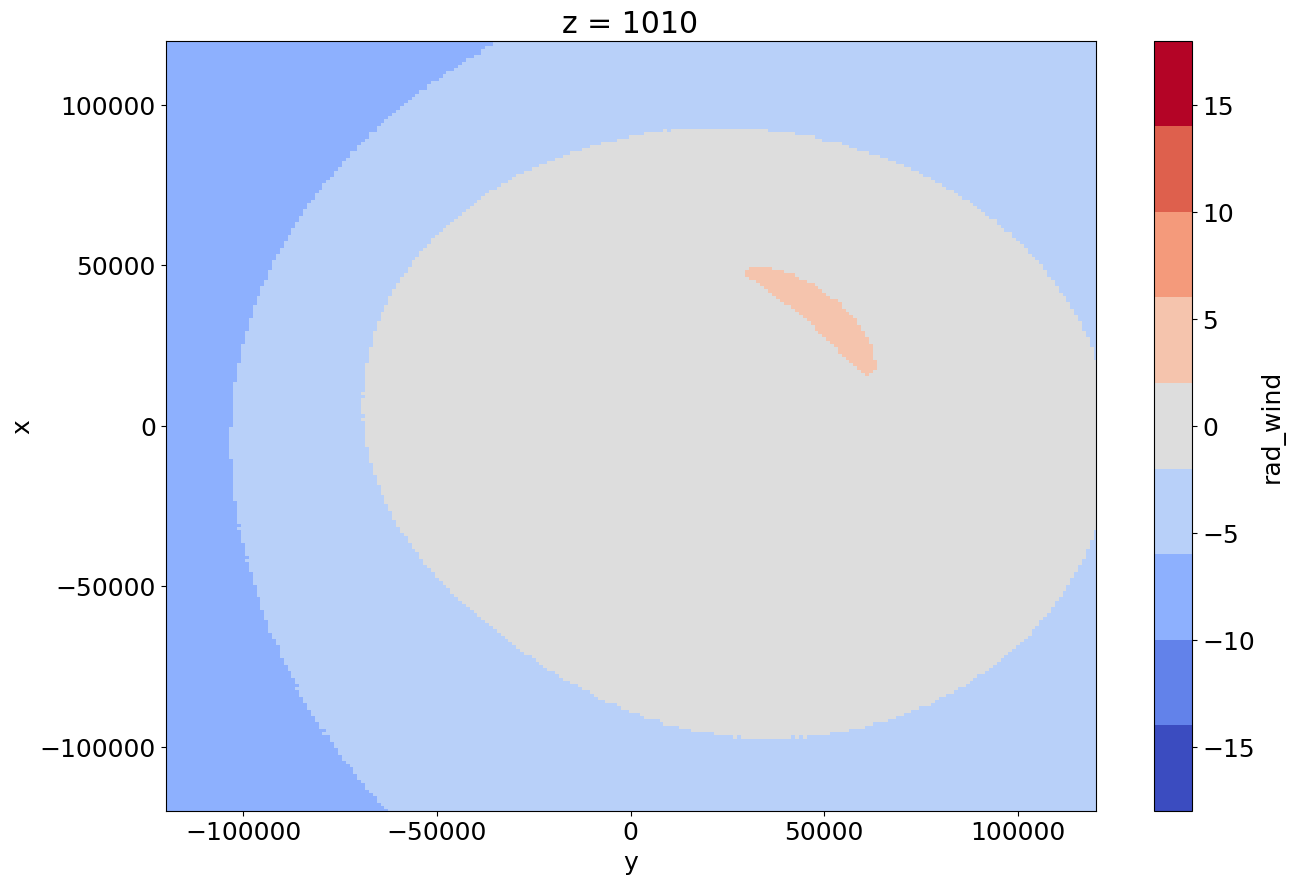

In [52]:
# (s)
cmap = plt.get_cmap('coolwarm', 9)

kep_car.sel(z=1010).rad_wind.plot(cmap=cmap, vmin=-18, vmax=18)

# Grid
plt.xlim(-120000, 120000)
plt.ylim(-120000, 120000)

(-120000.0, 120000.0)

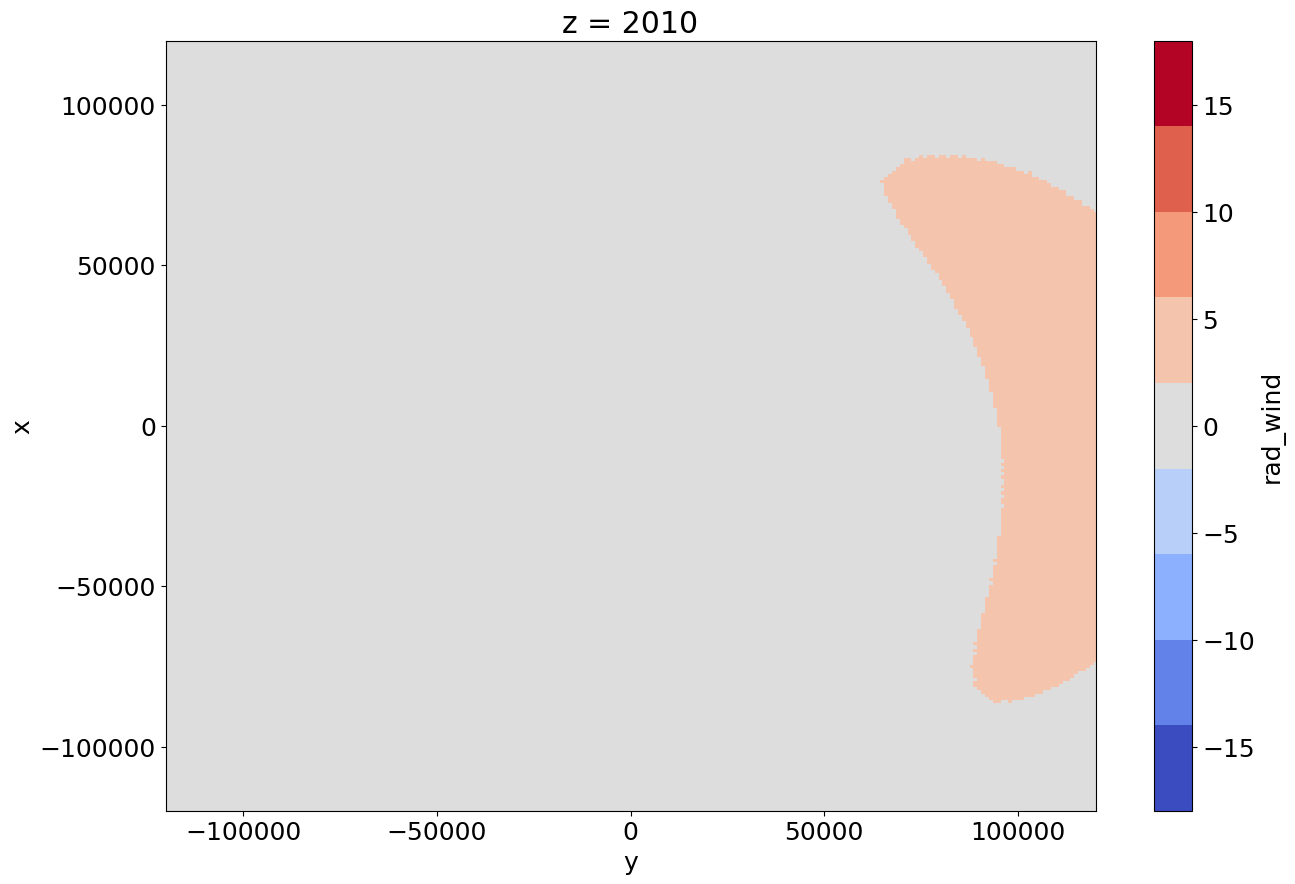

In [53]:
# (t)
cmap = plt.get_cmap('coolwarm', 9)

kep_car.sel(z=2010).rad_wind.plot(cmap=cmap, vmin=-18, vmax=18)

# Grid
plt.xlim(-120000, 120000)
plt.ylim(-120000, 120000)

#### Fig. 4

(-120000.0, 120000.0)

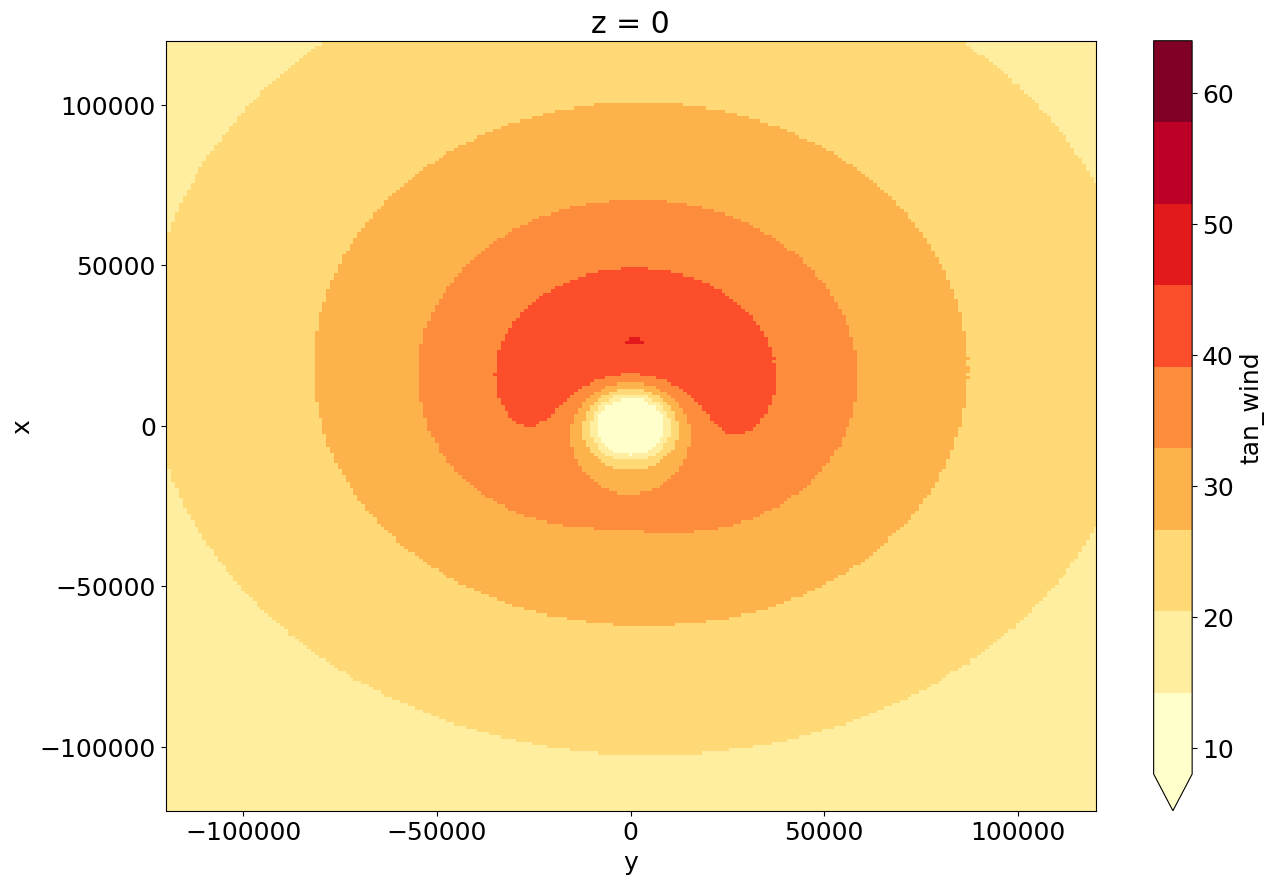

In [54]:
# (p)
cmap = plt.get_cmap('YlOrRd', 9)

kep_car.sel(z=0).tan_wind.plot(cmap=cmap, vmin=8, vmax=64)

# Grid
plt.xlim(-120000, 120000)
plt.ylim(-120000, 120000)

(-120000.0, 120000.0)

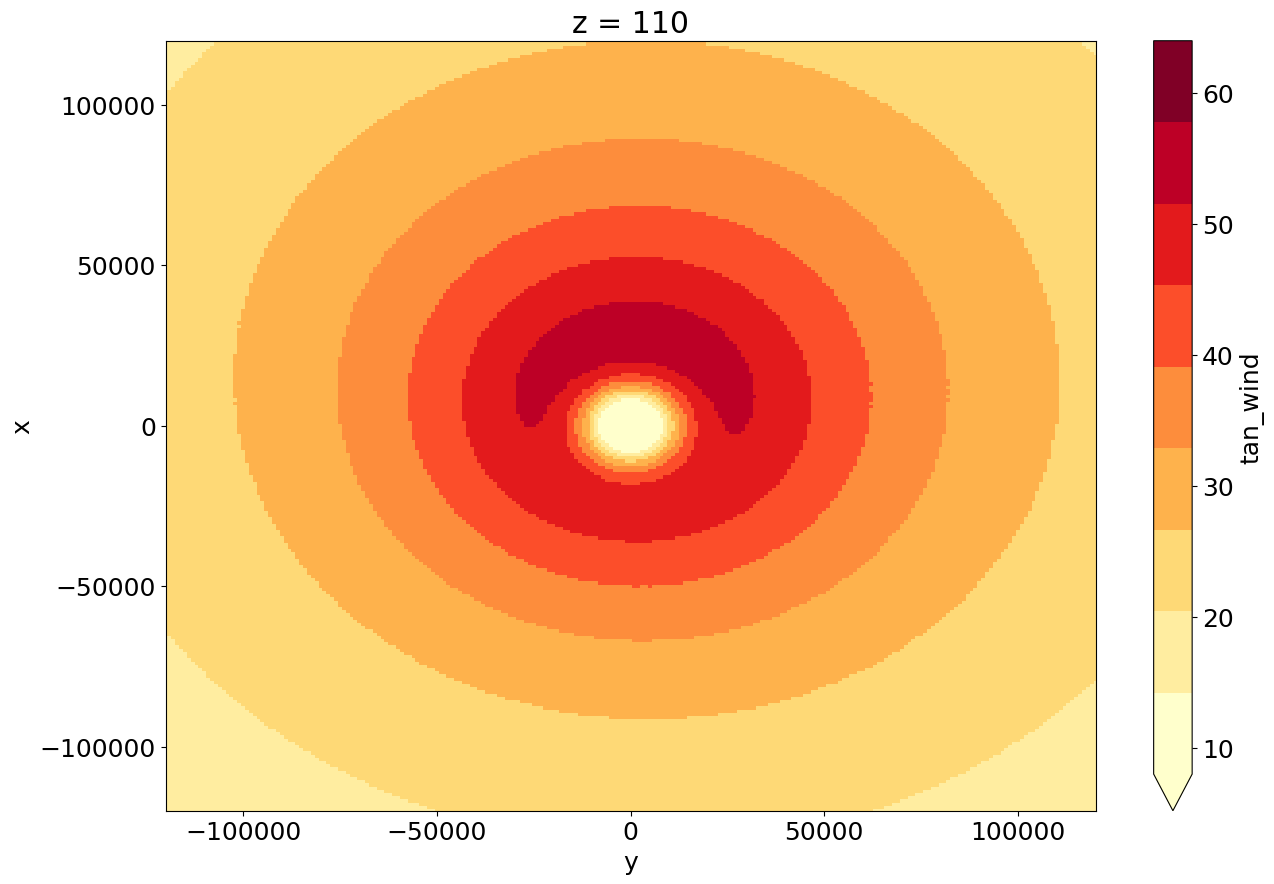

In [55]:
# (q)
cmap = plt.get_cmap('YlOrRd', 9)

kep_car.sel(z=110).tan_wind.plot(cmap=cmap, vmin=8, vmax=64)

# Grid
plt.xlim(-120000, 120000)
plt.ylim(-120000, 120000)

(-120000.0, 120000.0)

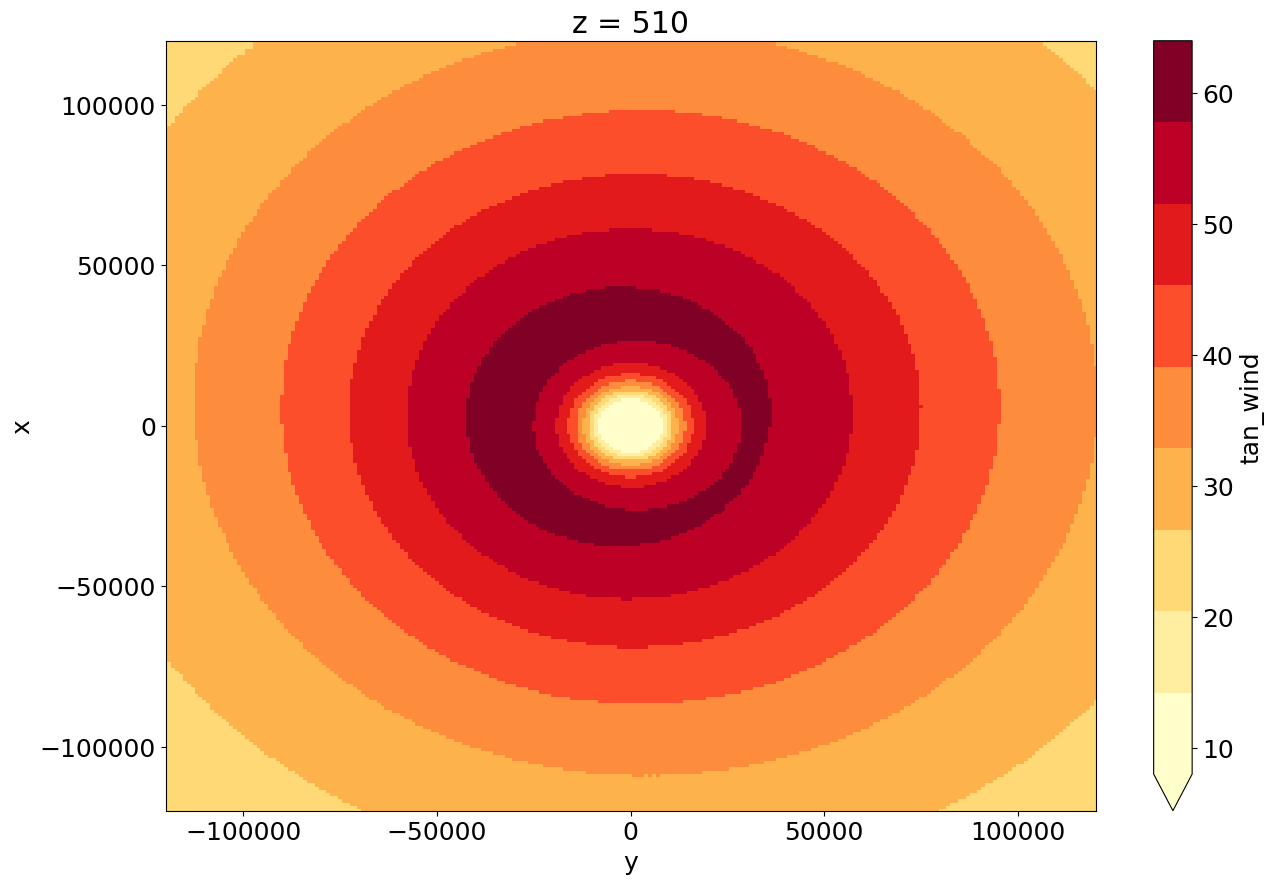

In [56]:
# (r)
cmap = plt.get_cmap('YlOrRd', 9)

kep_car.sel(z=510).tan_wind.plot(cmap=cmap, vmin=8, vmax=64)

# Grid
plt.xlim(-120000, 120000)
plt.ylim(-120000, 120000)

(-120000.0, 120000.0)

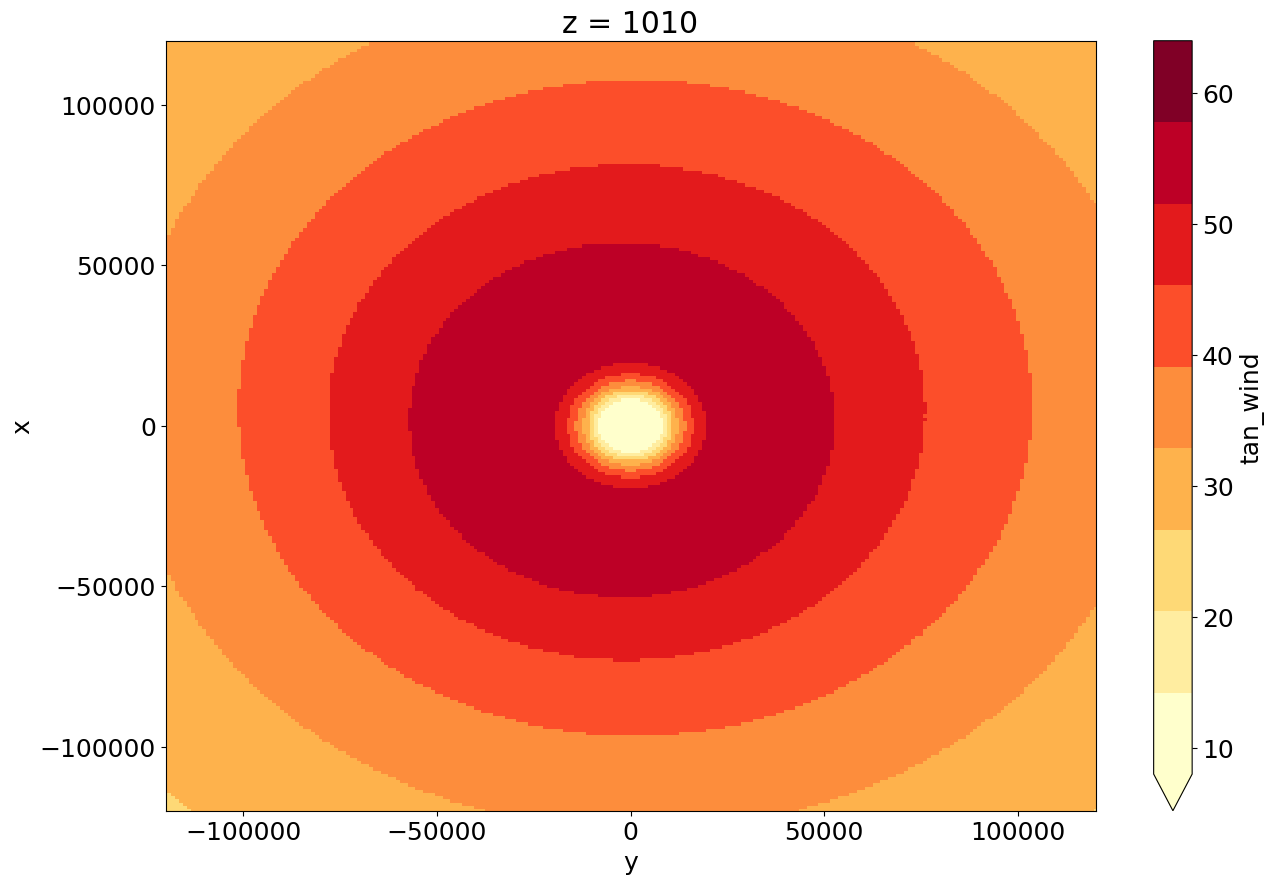

In [57]:
# (s)
cmap = plt.get_cmap('YlOrRd', 9)

kep_car.sel(z=1010).tan_wind.plot(cmap=cmap, vmin=8, vmax=64)

# Grid
plt.xlim(-120000, 120000)
plt.ylim(-120000, 120000)

(-120000.0, 120000.0)

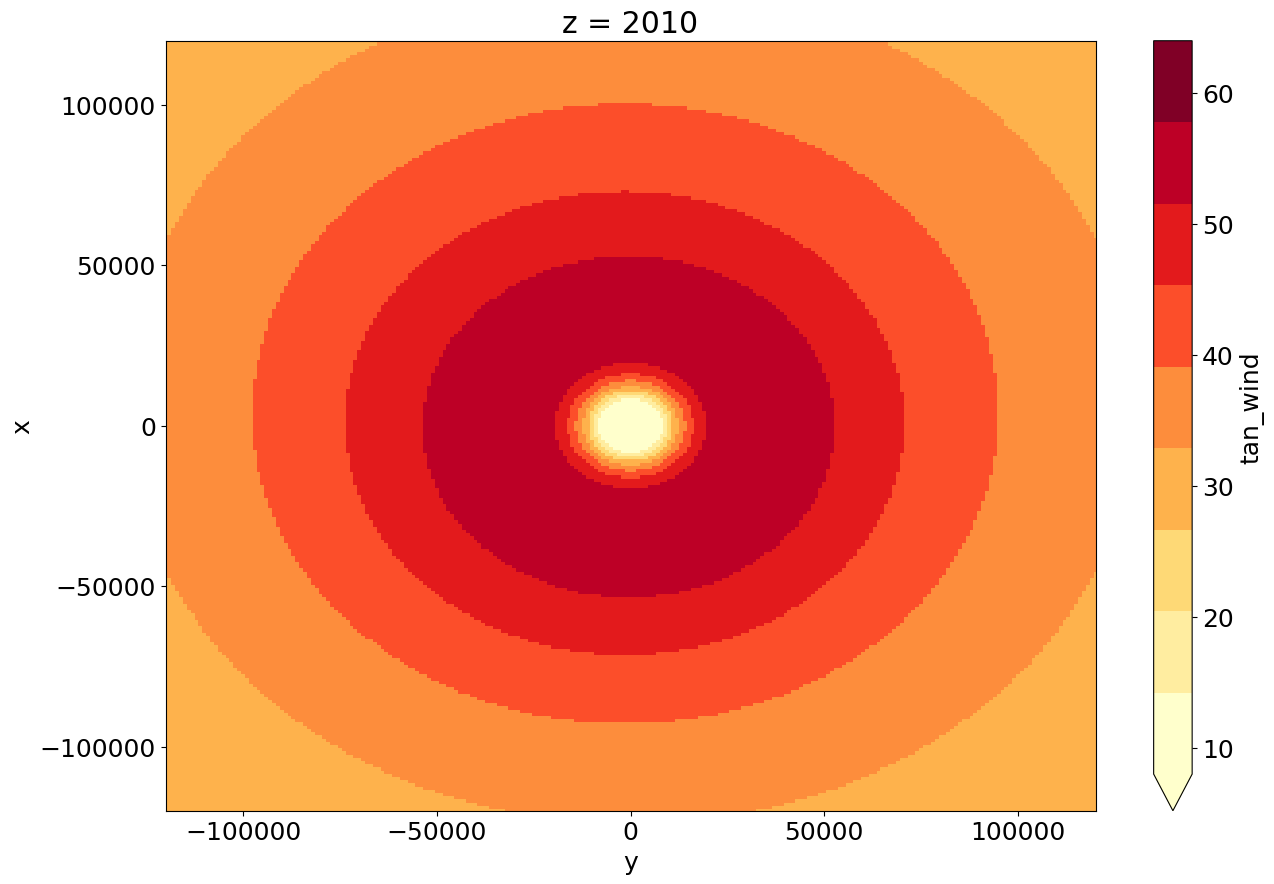

In [58]:
# (t)
cmap = plt.get_cmap('YlOrRd', 9)

kep_car.sel(z=2010).tan_wind.plot(cmap=cmap, vmin=8, vmax=64)

# Grid
plt.xlim(-120000, 120000)
plt.ylim(-120000, 120000)

#### Fig. 5 (asymmetries)

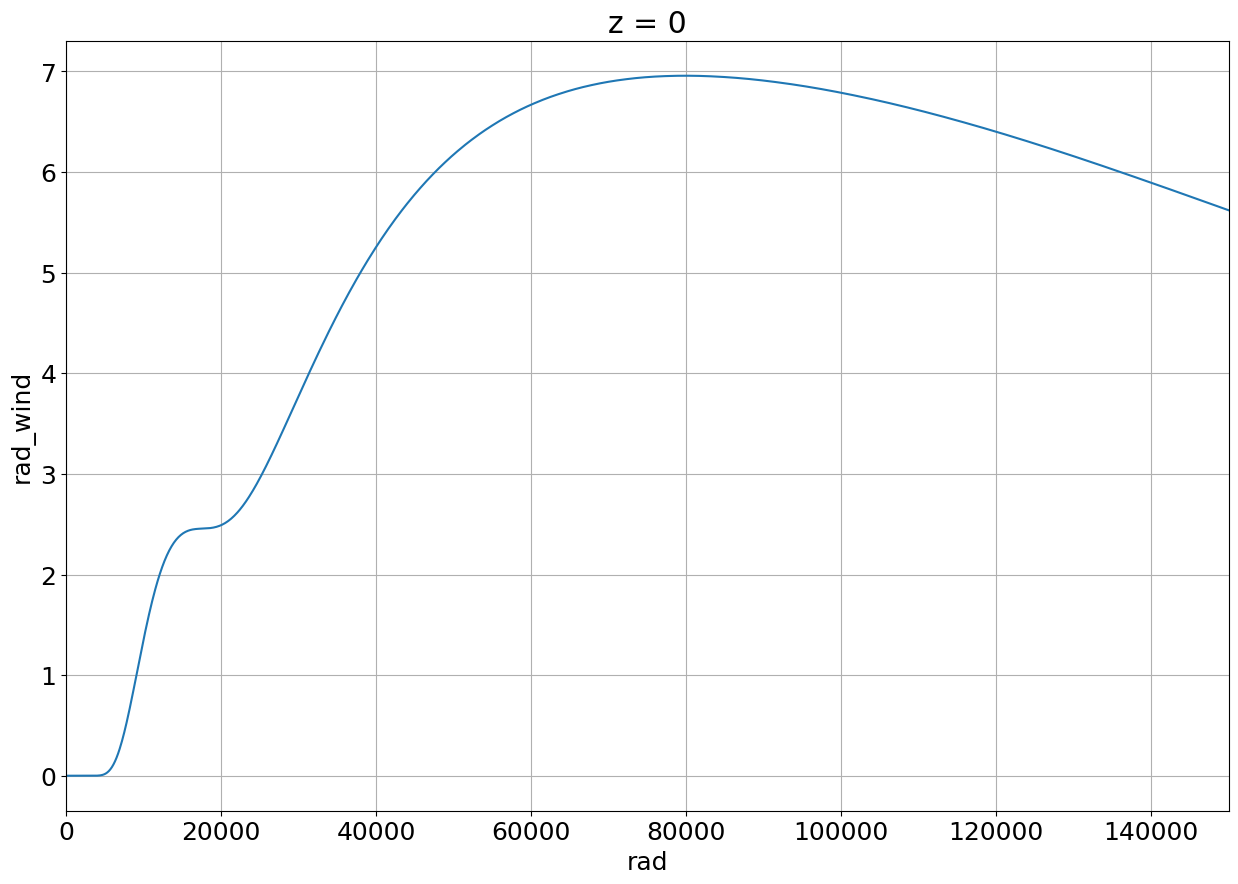

In [59]:
u_asym = kep_pol.sel(z=0).rad_wind.max(dim='theta') - kep_pol.sel(z=0).rad_wind.min(dim='theta')

u_asym.plot()
plt.xlim(0, 150000)
plt.grid()

In [113]:
# kep_pol.sel(z=0, rad=30000).rad_wind.plot()
# kep_pol.sel(z=0, rad=60000).rad_wind.plot(c='r')

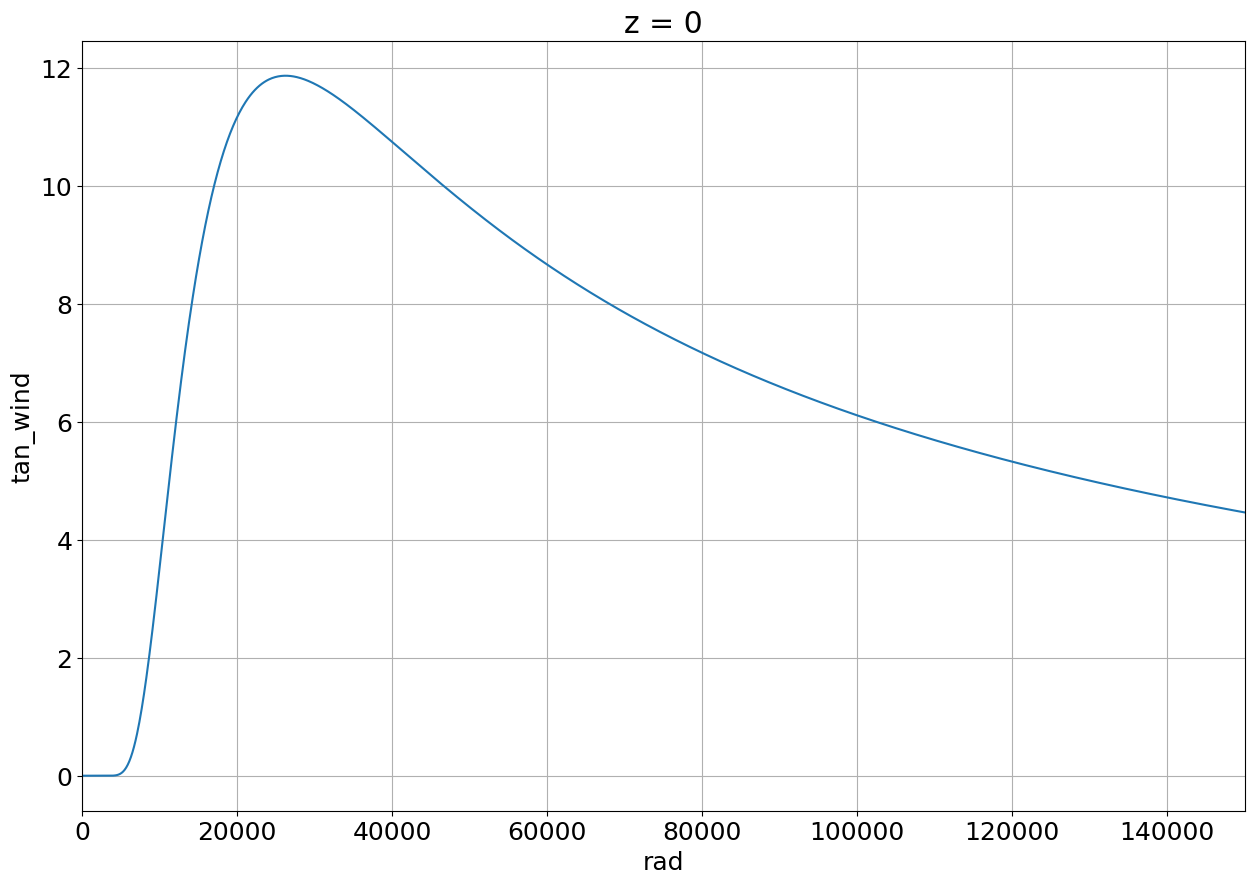

In [60]:
v_asym = kep_pol.sel(z=0).tan_wind.max(dim='theta') - kep_pol.sel(z=0).tan_wind.min(dim='theta')

v_asym.plot()
plt.xlim(0, 150000)
plt.grid()

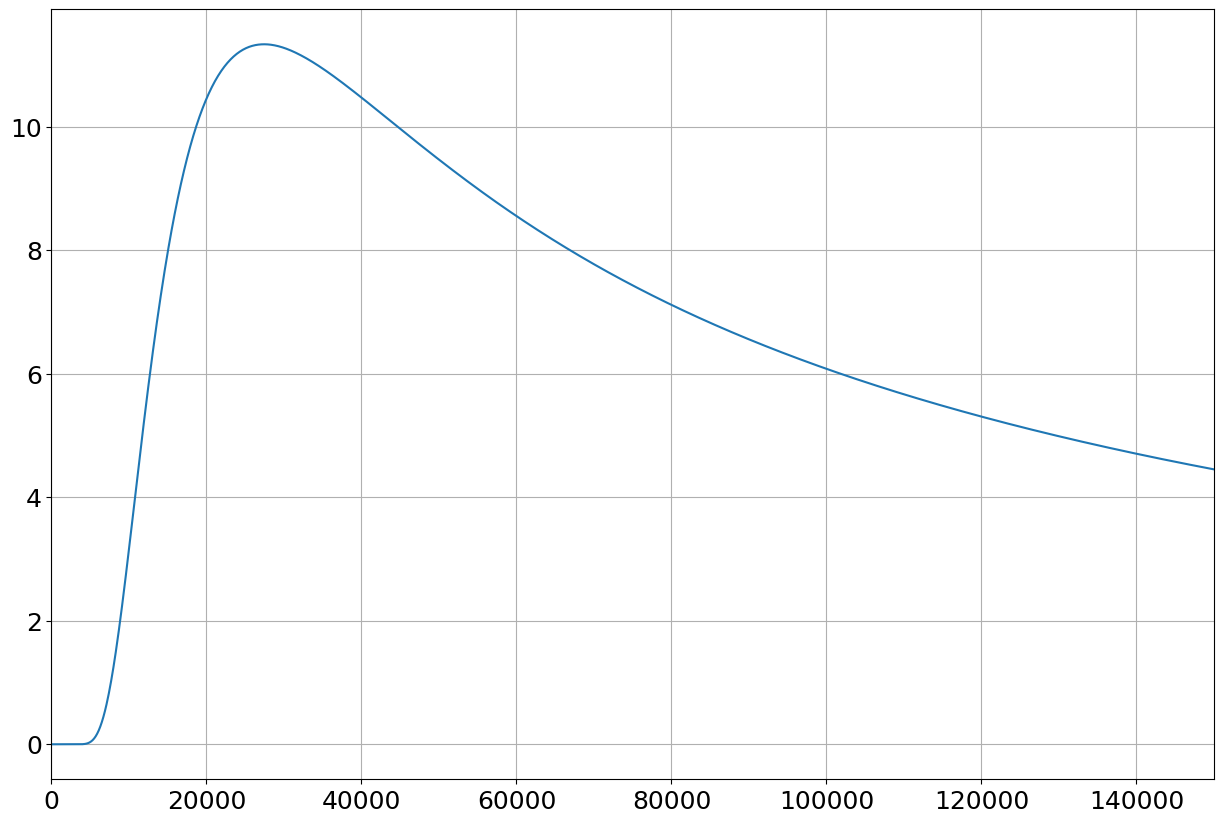

In [65]:
# Solely agradient flow
var    = v_1(THs[:1, :, :], Rs[:1, :, :], Vs[:1, :, :], K, C, c1, c2, fcr, z_ref, z_ref, h) + v0(Rs[:1, :, :], Vs[:1, :, :], K, C, fcr, z_ref, z_ref) + v1(THs[:1, :, :], Rs[:1, :, :], Vs[:1, :, :], K, C, c1, c2, fcr, z_ref, z_ref, h)
v_asym = np.max(var, axis=1) - np.min(var, axis=1)

plt.plot(rs, v_asym[0, :])

plt.xlim(0, 150000)
plt.grid()

In [78]:
# plt.plot(rs, np.mean((I(Rs, Vs, fcr) - Vs / Rs), axis=0))
# plt.grid()
# plt.ylim(0, 1e-3)

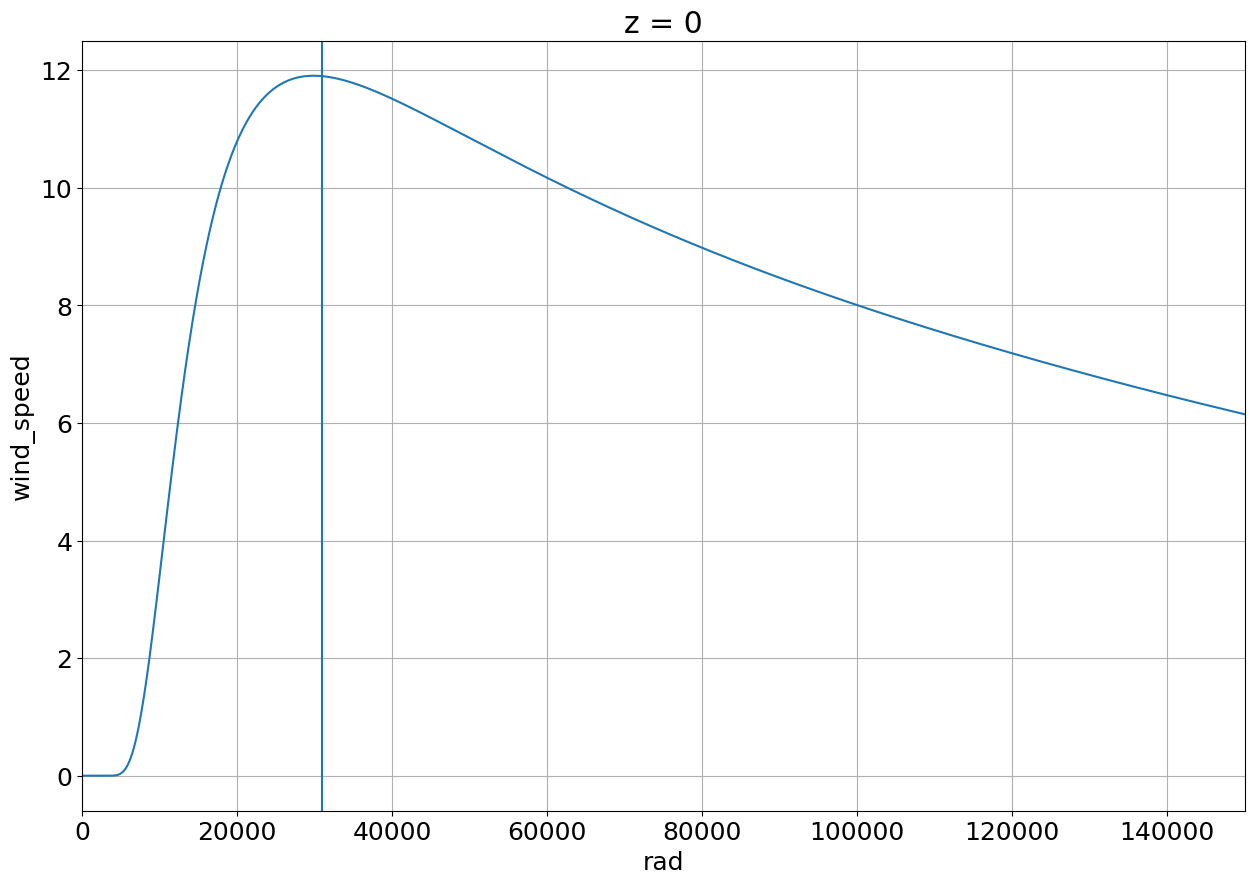

In [66]:
tot_asym = kep_pol.sel(z=0).wind_speed.max(dim='theta') - kep_pol.sel(z=0).wind_speed.min(dim='theta')

tot_asym.plot()
plt.axvline(Rmax)


plt.xlim(0, 150000)
plt.grid()

#### Tests with the drag coefficient

The drag asymmetry is proportional to both C and sqrt(c1 ** 2 + c2 ** 2).

Le front d'asymétrie (i.e entre le max et le min de Cd) a un angle arctan(c1 / c2) dans le sens antihoraire si h = 1 et horaire si h = -1, par rapport à l'axe des x > 0.

Par exemple pour c1 / c2 = 1, et h = -1, le front fait un angle 45° dans le sens horaire par rapport à l'axe des x > 0.

Attention à h et z_ref quand je fais mes analyses !! Mettre h = 1 et z_ref = 0 pour etre sur.

Pour un C donné (on peut commencer par en fixer un au hasard), l'azimuth (phase) du maximum observé d'asymétrie me donne le ratio c1 / c2, tandis que l'amplitude de l'asymétrie (par exemple en 2 Rmax) me donne sqrt(c1 ** 2 + c2 ** 2). Ces deux informations combinées me permettent donc d'obtenir c1 et c2. Ensuite, je peux varier C / sqrt(K) sans changer le champ de vent de surface. Pour déterminer ce ratio il faut une information en altitude. Mais on s'en fout car on a le même inflow angle quelque soient C et K à partir du moment où C / sqrt(K) est constant !!!

(-120000.0, 120000.0)

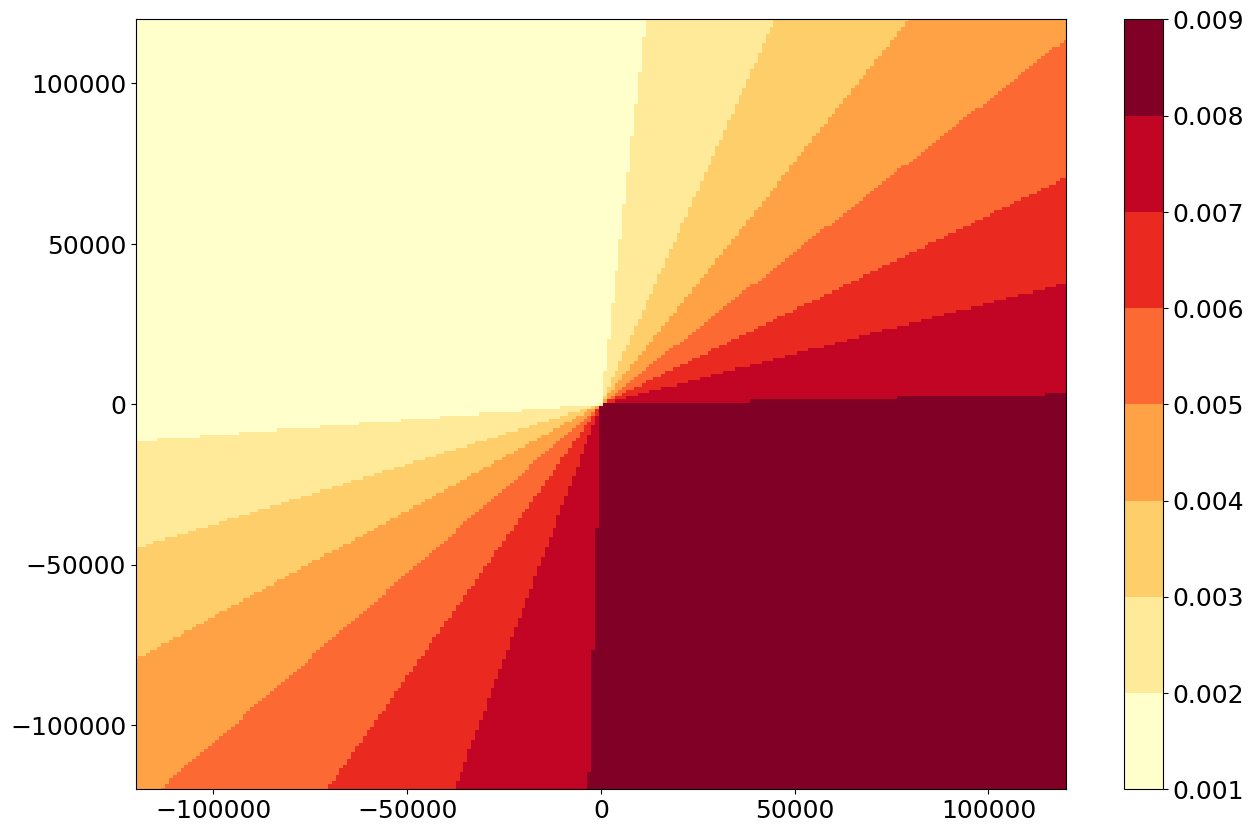

In [67]:
cmap = plt.get_cmap('YlOrRd', 8)

# cd = griddata((Xs.flatten(), Ys.flatten()), drag_coefficient(THs, C, c1, c2, h).flatten(),   (x_ref, y_ref), method='nearest')
cd = griddata((Xs[:1, :, :].flatten(), Ys[:1, :, :].flatten()), drag_coefficient(THs[:1, :, :], C, c2, c2, -1).flatten(),   (x_ref, y_ref), method='nearest')

plt.pcolormesh(x_ref, y_ref, cd, vmin=1e-3, vmax=9e-3, cmap=cmap)
plt.colorbar()

# Grid
plt.xlim(-120000, 120000)
plt.ylim(-120000, 120000)

In [146]:
np.rad2deg(np.arctan(c2 / c2))

np.float64(45.0)

(-120000.0, 120000.0)

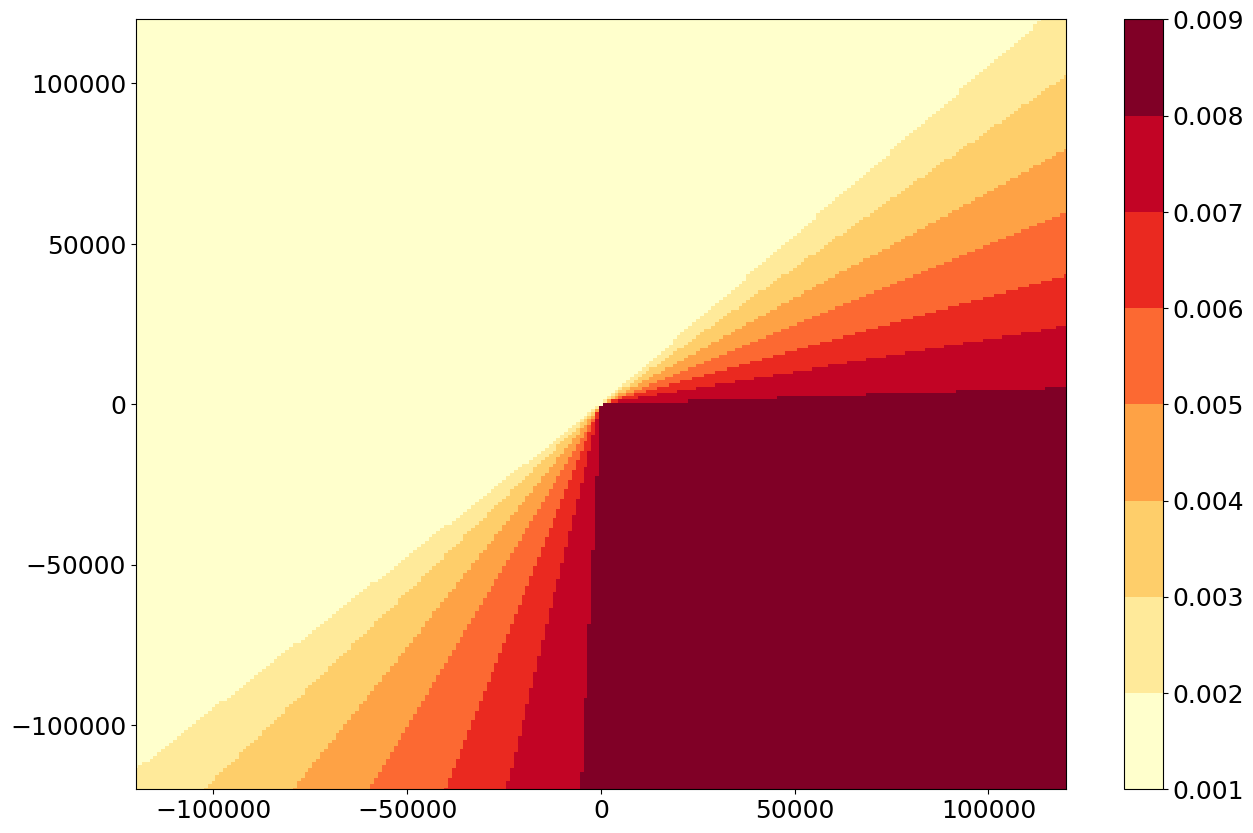

In [68]:
cmap = plt.get_cmap('YlOrRd', 8)

# cd = griddata((Xs.flatten(), Ys.flatten()), drag_coefficient(THs, C, c1, c2, h).flatten(),   (x_ref, y_ref), method='nearest')
cd = griddata((Xs[:1, :, :].flatten(), Ys[:1, :, :].flatten()), drag_coefficient(THs[:1, :, :], C / 2.15, c2 * 4, c2 * 4, -1).flatten(),   (x_ref, y_ref), method='nearest')

plt.pcolormesh(x_ref, y_ref, cd, vmin=1e-3, vmax=9e-3, cmap=cmap)
plt.colorbar()

# Grid
plt.xlim(-120000, 120000)
plt.ylim(-120000, 120000)